In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack, csr_matrix, csc_matrix
import matplotlib.pyplot as plt
from pyiga import assemble, bspline, vform, geometry, vis, solvers, utils, topology, ieti, algebra
from pyiga import ieti_cy, geometry_cy
#from sksparse.cholmod import cholesky
from pyiga import adaptive as adap
import json
from os.path import exists
import itertools
from scipy.sparse.linalg import aslinearoperator

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)
sys.setrecursionlimit(10000)
#import numba as nb    
#from numba import njit

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
class IetiDP:
    def __init__(self, MP, dir_data, neu_data=None, elim=True):
        self.space = MP
        self.elim = elim
        self.dir_idx=dict()
        self.dir_vals=dict()
        self.schur_exact=False
        kvs = self.space.mesh.kvs
        geos = self.space.mesh.geos
        for key in dir_data:
            for p,b in self.space.mesh.outer_boundaries[key]:
                idx_, vals_ = assemble.compute_dirichlet_bc(kvs[p], geos[p], [(b//2,b%2)], dir_data[key])
                if p in self.dir_idx:
                    self.dir_idx[p].append(idx_)
                    self.dir_vals[p].append(vals_)
                else:
                    self.dir_idx[p]=[idx_]
                    self.dir_vals[p]=[vals_]
                
        for p in self.dir_idx:
            self.dir_idx[p], lookup = np.unique(self.dir_idx[p], return_index = True)
            self.dir_vals[p] = np.concatenate(self.dir_vals[p])[lookup]
        
        if self.elim:
            p_intfs = np.array([[p1,p2] for (p1,_,_),(p2,_,_),_ in self.space.intfs], dtype=np.int32).T
            self.Basisk, self.N_ofs, self.N, self.B = ieti_cy.pyx_compute_decoupled_coarse_basis(self.space.Basis.tocsc(), MP.N_ofs.astype(np.int32), p_intfs)
        else:
            self.Basisk = [scipy.sparse.identity(self.space.N[p]) for p in range(self.space.numpatches)]
            self.B = self.space.Constr
            
        self.N = [Ba.shape[1] for Ba in self.Basisk]
        self.N_ofs = np.cumsum([0]+self.N)
        self.Bk = [self.B[:,self.N_ofs[p]:self.N_ofs[p+1]] for p in range(self.space.numpatches)]
        self.Basis=scipy.sparse.block_diag(self.Basisk).tocsr()
        self.P2Gk =[]
        
        for p in range(self.space.numpatches):
            X = self.Basisk[p].tocoo()
            idx = np.where(np.isclose(X.data,1))
            X.data, X.row, X.col = X.data[idx], X.row[idx], X.col[idx]
            D = (X.T@self.Basisk[p]).sum(axis=1).A.ravel()
            #assert all(abs(D)>1e-12), 'D has zeros.'
            #S = scipy.sparse.spdiags(1/D,[0],len(D),len(D))
            self.P2Gk.append(X.T)
            I = np.zeros(self.Basisk[p].shape[0])
            if p in self.dir_idx:
                I[self.dir_idx[p]] = 1
                self.dir_idx[p] = np.where(np.isclose(self.P2Gk[p]@I,1))[0]
        self.P2G = scipy.sparse.block_diag(self.P2Gk)
        
        if len(self.dir_idx)>0:
            self.global_dir_idx = np.concatenate([self.dir_idx[p] + self.N_ofs[p] for p in self.dir_idx])
        else:
            self.global_dir_idx = np.array([])
        self.free_dofs = np.setdiff1d(np.arange(self.N_ofs[-1]),self.global_dir_idx)
        self.free_dofs_pp = [np.arange(self.N[p]) if p not in self.dir_idx else np.setdiff1d(np.arange(self.N[p]),self.dir_idx[p]) for p in range(self.space.numpatches)]
        self.R_interior = {}
        self.R_skeleton = {}
        self.R_interfaces = {}
        for p in range(self.space.numpatches):
            Id = scipy.sparse.eye(self.N[p], format='csr')
            mask_skeleton = np.zeros(self.N[p], dtype=bool)
            intfs = np.where(self.Bk[p].getnnz(0) > 0)[0]
            #mask_skeleton[intfs]=True
            mask_interior = np.ones(self.N[p], dtype=bool)
            mask_interior[intfs]=False
            if p in self.dir_idx:
                mask_interior[self.dir_idx[p]]=False
                #mask_skeleton[self.dir_idx[p]]=False
            self.R_interior[p]=Id[mask_interior]
            for b in range(4):
                if not any([(p,b) in self.space.mesh.outer_boundaries[key] for key in self.space.mesh.outer_boundaries]):
                    mask_intf = np.zeros(self.N[p], dtype=bool)
                    interface_dofs = assemble.boundary_dofs(kvs[p],bdspec=[(b//2,b%2)],ravel=True)
                    mask_intf[interface_dofs] = True
                    if p in self.dir_idx:
                        mask_intf[self.dir_idx[p]]=False
                    mask_skeleton += mask_intf
                    self.R_interfaces[(p,b)] = Id[mask_intf]
            self.R_skeleton[p] = Id[mask_skeleton]
        self.Ck = [np.empty((0,self.space.N[p])) for p in range(self.space.numpatches)]
        self.Rk = []
        self.Prim={}
            
    def assemble(self, problem, f, a):
        self.Ak = [Ba.T @ assemble.assemble(problem, kvs, a=a[self.space.mesh.patch_domains[k]], bfuns=[('u',1), ('v',1)], geo=geo)@Ba for k, (Ba, ((kvs, geo),_)) in enumerate(zip(self.Basisk, self.space.mesh.patches))]
        self.rhsk = [Ba.T @ assemble.assemble('f * v * dx', kvs, bfuns=[('v',1)], geo=geo, f=f[self.space.mesh.patch_domains[k]]).ravel() for k, (Ba, ((kvs, geo),_)) in enumerate(zip(self.Basisk,self.space.mesh.patches))]
        self.BCRestr = {p:assemble.RestrictedLinearSystem(self.Ak[p], self.rhsk[p], (self.dir_idx[p],self.dir_vals[p])) for p in self.dir_idx}
        self.rhsk = [rhsk if p not in self.dir_idx else self.BCRestr[p].b for p, rhsk in enumerate(self.rhsk)]
        self.Ak = [Ak if p not in self.dir_idx else self.BCRestr[p].A for p, Ak in enumerate(self.Ak)]
        
    def generate_prim(self, elim, fat):
        Nodes = self.space.get_nodes()
        self.Prim = {}
        i=0
        total_dofs=set()
        
        if elim:
            if fat:
                for key in Nodes:
                    if isinstance(key,int32):
                        dofs = self.Basis.tocsr()[Nodes[key][0],:].indices
                        self.Prim[i] = (dofs,np.ones(len(dofs)))
                        i+=1
                    else:
                        dofs = self.Basis.tocsr()[Nodes[key][1],:].indices
                        for dof in dofs:
                            if dof not in total_dofs:
                                total_dofs.add(dof)
                                dofs = np.unique(self.B.tocsr()[self.B.tocsc()[:,dof].indices,:].indices)
                                self.Prim[i] = (dofs,np.ones(len(dofs)))
                                i+=1
            else:
                for key in Nodes:
                    if isinstance(key,int32):
                        dofs = self.Basis.tocsr()[Nodes[key][0],:].indices
                        self.Prim[i] = (dofs,np.ones(len(dofs)))
                        i+=1
                    else:
                        constr = (self.space.Constr.tocsc()[:,Nodes[key][0][0]]==1).indices
                        coeffs = abs(self.space.Constr[constr,:][:,Nodes[key][1]].data)
                        dofs_coarse = self.Basis.tocsr()[Nodes[key][1],:].indices
                        dofs=[]
                        for dof in dofs_coarse:
                            found_dofs = np.unique(self.B.tocsr()[self.B.tocsc()[:,dof].indices,:].indices)
                            dofs.append(found_dofs)
                        self.Prim[i] = (np.concatenate(dofs),np.repeat(coeffs,len(found_dofs)))
                        i+=1
        else:
            for key in Nodes:
                if isinstance(key,int32):    #regular corner
                    dofs = self.Basis.tocsr()[Nodes[key][0],:].indices
                    self.Prim[i] = (dofs,np.ones(len(dofs)))
                    i+=1
                else:                        #T-junction
                    constr = (self.space.Constr.tocsc()[:,Nodes[key][0][0]]==1).indices
                    coeffs = abs(self.space.Constr[constr,:][:,Nodes[key][1]].data)
                    dofs_coarse = Nodes[key][1]
                    dofs=np.concatenate([Nodes[key][0],Nodes[key][1]])
                    coeffs = np.concatenate([np.ones(len(Nodes[key][0])),coeffs])
                    self.Prim[i] = (dofs,coeffs)
                    i+=1
        
    def construct_primal_constraints(self, redundant=False, fat=True):
        self.Ck = []
        self.Rk = []
        kvs = self.space.mesh.kvs
        geos = self.space.mesh.geos
        self.eliminate_constraints = np.array([], dtype=int)
        Nodes=self.space.get_nodes(dir_boundary = True)
        
        self.generate_prim(elim=self.elim, fat=fat)
        if self.Prim:
            loc_c_prim = np.concatenate([self.Prim[key][0] for key in self.Prim])
            coeffs = np.concatenate([self.Prim[key][1] for key in self.Prim])
        else:
            loc_c_prim = np.array([])
            coeffs = np.array([])
        loc_c_prim_idx = np.repeat(np.arange(len(self.Prim)),[len(self.Prim[i][0]) for i in self.Prim])
        p_idx = [(loc_c_prim >= self.N_ofs[p]) & (loc_c_prim < self.N_ofs[p+1]) for p in range(self.space.numpatches)]
        self.Prim_pp = {p : (loc_c_prim[p_idx[p]],coeffs[p_idx[p]],loc_c_prim_idx[p_idx[p]]) for p in range(self.space.numpatches)}

        
        for (p1,b1) in self.space.L_intfs:
            R1 = self.R_interfaces[(p1,b1)]
            diag=np.ones(R1.shape[1])
            idx = np.where(np.isclose(self.Prim_pp[p1][1],1))[0]
            diag[self.Prim_pp[p1][0][idx]-self.N_ofs[p1]]=0
            R1 = R1@scipy.sparse.spdiags(diag,0,R1.shape[1],R1.shape[1])
            R1.eliminate_zeros()
            self.R_interfaces[(p1,b1)] = R1[R1.getnnz(1)>0,:]
            for (p2,b2) in self.space.L_intfs[(p1,b1)]:
                R2 = self.R_interfaces[(p2,b2)]
                diag=np.ones(R2.shape[1])
                idx = np.where(np.isclose(self.Prim_pp[p2][1],1))[0]
                diag[self.Prim_pp[p2][0][idx]-self.N_ofs[p2]]=0
                R2 = R2@scipy.sparse.spdiags(diag,0,R2.shape[1],R2.shape[1])
                R2.eliminate_zeros()
                self.R_interfaces[(p2,b2)] = R2[R2.getnnz(1)>0,:]
                    
        for p in range(MP.numpatches):
            c_primal_free = self.Prim_pp[p][0] - self.N_ofs[p]
            data = self.Prim_pp[p][1]
            idx = np.bincount(self.Prim_pp[p][2])
            idx = idx[idx>0]
            rows = np.repeat(np.arange(len(idx)),idx)
            cols = c_primal_free
            ck = coo_matrix((data, (rows, cols)),(len(idx),self.N[p])).tocsc()
            ck = ck[:,self.free_dofs_pp[p]]
            self.Ck.append(ck.tocsr())
            m, n = ck.shape[0], len(self.Prim)
            jj = np.unique(self.Prim_pp[p][2])
            self.Rk.append(scipy.sparse.coo_matrix((np.ones(m),(np.arange(m),jj)),(m,n)))
            
        if not redundant:
            if self.elim:
                if fat:
                    nnz_per_row = self.B[:,np.concatenate([self.Prim_pp[p][0] for p in range(self.space.numpatches)])].getnnz(axis=1)
                    self.eliminate_constraints = np.where(nnz_per_row > 0)[0]
                else:
                    dofs = [Nodes[key][0] for key in Nodes if isinstance(key,int32)]
                    if len(dofs)>0:
                        dofs = np.concatenate([Nodes[key][0] for key in Nodes if isinstance(key,int32)])
                    dofs_new = (self.Basis[dofs,:]==1).indices
                    self.eliminate_constraints = np.where(self.B[:,dofs_new].getnnz(axis=1))
            else:
                self.eliminate_constraints = (MP.Constr.tocsc()[:,np.concatenate([Nodes[key][0] for key in Nodes])]==1).indices
                    
        keep_constr = np.setdiff1d(np.arange(self.B.shape[0]),self.eliminate_constraints)
        self.B = self.B[keep_constr,:]
        self.Bk = [B[keep_constr,:] for B in self.Bk]
        self.C = scipy.sparse.block_diag(self.Ck)
        
    def construct_primal_basis(self):
        self.PsiK=[]
        self.Deltak=[]
        self.loc_solver = []
        self.A_prim = np.zeros(2*(len(self.Prim),))
        for p in range(len(self.space.mesh.patches)):
            a = self.Ak[p]
            c = self.Ck[p]
            RHS = np.vstack([np.zeros((a.shape[0],c.shape[0])), np.identity(c.shape[0])])
            self.loc_solver.append(solvers.make_solver(scipy.sparse.bmat([[a,    c.T], [c,    None]], format='csr'), spd=False, symmetric=True))
            psi = self.loc_solver[p].dot(RHS)
            psi, delta = psi[:a.shape[0],], psi[a.shape[0]:,]
            if psi.ndim==1: psi=psi[:,None]
            if delta.ndim==1: delta=delta[:,None]
            self.PsiK.append(psi@self.Rk[p])
            self.Deltak.append(delta)
            self.A_prim -= self.Rk[p].T@delta@self.Rk[p]
        self.Psi=np.vstack(self.PsiK)
        
    def remove_dir_from_system(self):
        self.B = self.B[:,self.free_dofs]
        self.keep = np.where(self.B.getnnz(1)>0)[0]
        self.B=self.B[self.keep,:]
        idx_p = [(self.free_dofs < self.N_ofs[p+1]) & (self.free_dofs >= self.N_ofs[p]) for p in range(self.space.numpatches)]
        self.Bk = [self.B[:,idx_p[p]] for p in range(self.space.numpatches)]
        for p in self.dir_idx:
            self.R_skeleton[p] = self.R_skeleton[p][:,self.free_dofs_pp[p]]
            self.R_interior[p] = self.R_interior[p][:,self.free_dofs_pp[p]]
            for b in range(4):
                if not any([(p,b) in self.space.mesh.outer_boundaries[key] for key in self.space.mesh.outer_boundaries]):
                    self.R_interfaces[(p,b)] = self.R_interfaces[(p,b)][:,self.free_dofs_pp[p]]

    def compute_F(self):
        self.Bk_ = [aslinearoperator(scipy.sparse.bmat([[b,np.zeros((b.shape[0],self.Ck[p].shape[0]))]], format='csr')) for p,b in enumerate(self.Bk)] 
        rhs = np.concatenate(self.rhsk)
        self.rhsk_ = [np.concatenate([f,np.zeros(self.Ck[p].shape[0])]) for p,f in enumerate(self.rhsk)]
        if len(self.Prim)==0:
            self.loc_solver = [solvers.make_solver(a, spd=False, symmetric=True) for a in self.Ak]
            self.Psi = np.empty((self.B.shape[1],0))
        self.BP = self.B@self.Psi
            
        F2 = sum([b@Ak_inv.dot(b.T) for b, Ak_inv in zip(self.Bk_, self.loc_solver)])
        b2 = np.sum([b.dot(Ak_inv.dot(f)) for b, Ak_inv,f in zip(self.Bk_, self.loc_solver, self.rhsk_)],axis=0)
        if len(self.Prim)!=0:
            self.solver_prim = solvers.make_solver(self.A_prim, spd=True, symmetric=True)
            F1 = aslinearoperator(self.BP@self.solver_prim.dot(self.BP.T)) 
            b1 = self.BP@self.solver_prim.dot(self.Psi.T@rhs)
            return F1+F2, b1+b2
        return F2, b2

    def compute_S(self):
        B = self.B
        Bk = self.Bk
        self.B_gamma = scipy.sparse.hstack([Bk[p]@self.R_skeleton[p].T for p in range(self.space.numpatches)])
        self.Aii = [self.R_interior[p]@self.Ak[p]@self.R_interior[p].T for p in range(self.space.numpatches)]
        self.Abb = [aslinearoperator(self.R_skeleton[p]@self.Ak[p]@self.R_skeleton[p].T) for p in range(self.space.numpatches)]
        self.Abi = [aslinearoperator(self.R_skeleton[p]@self.Ak[p]@self.R_interior[p].T) for p in range(self.space.numpatches)]
        self.S = [Abb - Abi@solvers.make_solver(Aii, spd=True).dot(Abi.T) for Abb,Abi,Aii in zip(self.Abb,self.Abi,self.Aii)]
        self.S = [s@np.eye(s.shape[0]) for s in self.S]
        self.schur_exact=True
        self.S_ofs = np.cumsum([0]+[s.shape[0] for s in self.S])

        self.S_prim = np.zeros(2*(len(self.Prim),))
        PsiK=[]
        for p in range(self.space.numpatches):
            s = self.S[p]
            c = self.Ck[p]@self.R_skeleton[p].T
            RHS = np.vstack([np.zeros((s.shape[0],c.shape[0])), np.identity(c.shape[0])])
            sol = solvers.make_solver(scipy.sparse.bmat([[s,    c.T], [c,    None]], format='csr'), spd=False, symmetric=True)
            psi = sol.dot(RHS)
            psi, delta = psi[:s.shape[0],], psi[s.shape[0]:,]
            if psi.ndim==1: psi=psi[:,None]
            if delta.ndim==1: delta=delta[:,None]
            self.S_prim -= self.Rk[p].T@delta@self.Rk[p]
            PsiK.append(psi@self.Rk[p])
        self.Psi_gamma=np.vstack(PsiK)
    
    def MsD(self, method="diagonal", as_matrix = False):
        if not self.schur_exact:
            B = self.B
            Bk = self.Bk
            self.B_gamma = scipy.sparse.hstack([Bk[p]@self.R_skeleton[p].T for p in range(self.space.numpatches)])
            self.Aii = [self.R_interior[p]@self.Ak[p]@self.R_interior[p].T for p in range(self.space.numpatches)]
            self.Abb = [aslinearoperator(self.R_skeleton[p]@self.Ak[p]@self.R_skeleton[p].T) for p in range(self.space.numpatches)]
            self.Abi = [aslinearoperator(self.R_skeleton[p]@self.Ak[p]@self.R_interior[p].T) for p in range(self.space.numpatches)]
            self.S = [Abb - Abi@solvers.make_solver(Aii, spd=True).dot(Abi.T) for Abb,Abi,Aii in zip(self.Abb,self.Abi,self.Aii)]
        else:
            if as_matrix:
                self.compute_S()
            else:
                pass
                
        if method=="pseudo":   ###TODO: Do not compute matrix exactly but use least squares as an operator
            t=time.time()
            P = np.linalg.pinv(self.B_gamma.toarray())
            P[abs(P)<1e-12]=0
            self.BgD=scipy.sparse.csr_matrix(P).T
            print("Computing pseudoinverse took "+str(time.time()-t)+" seconds.")
        elif method=="diagonal":
            D = self.B_gamma.getnnz(axis=0)
            D = 1/(1+D)
            self.D = scipy.sparse.diags(D, format='csr')
            self.BgD = self.B_gamma@self.D
        elif method=="selection":
            B = self.B_gamma.tocsc()
            idx = 1*(B.indptr[1:]-B.indptr[:-1]==1) & np.isclose(B.sum(axis=0).A[0],1)
            self.D=scipy.sparse.diags([idx],[0])
            self.BgD = self.B_gamma@self.D
        elif method=="deluxe":
            M_deluxe = []
            for (p1,b1) in self.space.L_intfs:
                A=[]
                B=[]
                idofs1 = []
                P2 = []
                for (p2,b2) in self.space.L_intfs:
                    _, rb2 = self.Rbb_edges[(p1,p2)]
                    rb2I = scipy.sparse.vstack([self.Rii[p2],rb2[rb2.getnnz(1)>0,:]])
                    A.append(rb2I@self.Ak[p2]@rb2I.T)
                    B.append(self.Bk[p2]@rb2I.T)
                    P2.append(self.B_gamma[:,self.S_ofs[p2]:self.S_ofs[p2+1]]@rb2[:,rb2.getnnz(0)>0])
                P = scipy.sparse.hstack(P2)
                B = scipy.sparse.hstack(B)
                r_idx = B.getnnz(1)>0
                n_c = sum(r_idx)
                idofs1 = assemble.boundary_dofs(self.space.mesh.kvs[p1],bdspec=[(b1//2,b1%2)],ravel=True)[1:-1]
                idx1 = np.zeros(self.Rbb[p1].shape[1])
                idx1[idofs1]=1
                rb1 = self.Rbb[p1]@scipy.sparse.diags(idx1)
                rb1I = scipy.sparse.vstack([self.Rii[p1],rb1[rb1.getnnz(1)>0,:]])
                A = scipy.sparse.block_diag([rb1I@self.Ak[p1]@rb1I.T]+A)
                B = scipy.sparse.hstack([self.Bk[p1]@rb1I.T,B])
                B=B[r_idx,:]
                Mat = scipy.sparse.block_array([[A, B.T],[B, None]], format="csc")
                n = Mat.shape[0]
                X = aslinearoperator(P@scipy.sparse.hstack([scipy.sparse.csc_matrix((n_c,n-n_c)),scipy.sparse.identity(n_c, format='csc')]))
                M_deluxe.append(X@solvers.make_solver(Mat).dot(X.T))
            
            return np.array(M_deluxe).sum()
            
        print("Convergence condition: "+str(scipy.sparse.linalg.norm(self.B_gamma@self.BgD.T@self.B_gamma-self.B_gamma)))
        # for p in range(self.space.numpatches):
        #     print(self.BgD[:,ofs[p]:ofs[p+1]].shape, self.S[p].shape, self.BgD[:,ofs[p]:ofs[p+1]].T.shape)
        if self.schur_exact:
            return np.array([self.BgD[:,self.S_ofs[p]:self.S_ofs[p+1]]@self.S[p]@self.BgD[:,self.S_ofs[p]:self.S_ofs[p+1]].T for p in range(self.space.numpatches)]).sum(axis=0)
        else:
            return sum([aslinearoperator(self.BgD[:,self.S_ofs[p]:self.S_ofs[p+1]])@self.S[p].dot(aslinearoperator(self.BgD[:,self.S_ofs[p]:self.S_ofs[p+1]].T)) for p in range(self.space.numpatches)])

    def construct_solution(self, lam):
        u=np.zeros(self.space.N_ofs[-1])
        u_prim = self.solver_prim.dot(self.Psi.T@(np.concatenate(self.rhsk)-self.B.T@lam))
        for p in range(self.space.numpatches):
            sol = self.loc_solver[p].dot(np.r_[self.rhsk[p]-self.Bk[p].T@lam,np.zeros(self.Ck[p].shape[0])])[:self.Ck[p].shape[1]] + self.PsiK[p]@u_prim
            if p in self.BCRestr:
                sol = self.BCRestr[p].complete(sol)
            u[self.space.N_ofs[p]:self.space.N_ofs[p+1]]=self.Basisk[p]@sol
        return u
        

In [3]:
def checkerboard(deg,N,k=0):
    geos = [
    geometry.unit_square(),
    geometry.unit_square().translate((1,0)),
    geometry.unit_square().translate((0,1)),
    geometry.unit_square().translate((1,1)),
    ]

    kvs=4*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
    patches = [(kvs, g) for kvs, g in zip(kvs,geos)]

    # set up a PatchMesh object, which detects interfaces between patches
    M = topology.PatchMesh(patches)
    for j in range(k):
        M.h_refine(patches = {i : -1 for i in range(4) if i%2==1})
    return M

In [4]:
def checkerboard1(deg,N,k):
    geos = [
    geometry.unit_square(),
    geometry.unit_square().translate((1,0)),
    geometry.unit_square().translate((2,0)),
    geometry.unit_square().translate((0,1)),
    geometry.unit_square().translate((1,1)),
    geometry.unit_square().translate((2,1)),
    geometry.unit_square().translate((0,2)),
    geometry.unit_square().translate((1,2)),
    geometry.unit_square().translate((2,2)),
    ]

    #kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),) if i%2==0 else 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),) for i in range(len(geos))]
    #kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),), 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),),2 * (bspline.make_knots(p, 0.0, 1.0, k*N),), 2 * (bspline.make_knots(p, 0.0, 1.0, N),)] # 15
    kvs=9*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
    patches = [(kvs, g) for kvs, g in zip(kvs,geos)]

    # set up a PatchMesh object, which detects interfaces between patches
    M = topology.PatchMesh(patches)
    for j in range(k):
        M.h_refine(patches = {i : -1 for i in range(9) if i%2==1})
    return M

In [5]:
def checkerboard2(deg,N,k):
    geos = [
        geometry.annulus(r1=1,r2=4/3,phi=np.pi/6),
        geometry.annulus(r1=4/3,r2=5/3,phi=np.pi/6),
        geometry.annulus(r1=5/3,r2=2,phi=np.pi/6),
        geometry.annulus(r1=1,r2=4/3,phi=np.pi/6).rotate_2d(np.pi/6),
        geometry.annulus(r1=4/3,r2=5/3,phi=np.pi/6).rotate_2d(np.pi/6),
        geometry.annulus(r1=5/3,r2=2,phi=np.pi/6).rotate_2d(np.pi/6),
        geometry.annulus(r1=1,r2=4/3,phi=np.pi/6).rotate_2d(np.pi/3),
        geometry.annulus(r1=4/3,r2=5/3,phi=np.pi/6).rotate_2d(np.pi/3),
        geometry.annulus(r1=5/3,r2=2,phi=np.pi/6).rotate_2d(np.pi/3),
    ]

    #kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),) if i%2==0 else 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),) for i in range(len(geos))]
    #kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),), 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),),2 * (bspline.make_knots(p, 0.0, 1.0, k*N),), 2 * (bspline.make_knots(p, 0.0, 1.0, N),)] # 15
    kvs=9*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
    patches = [(kvs, g) for kvs, g in zip(kvs,geos)]

    # set up a PatchMesh object, which detects interfaces between patches
    M = topology.PatchMesh(patches)
    for j in range(k):
        M.h_refine(patches = {i : -1 for i in range(9) if i%2==0})
    return M

In [6]:
def Lshape(deg, N, depth=0):
 
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.annulus(r1=1.5,phi=np.pi/4),
        geometry.annulus(r1=1.5,phi=np.pi/4).rotate_2d(np.pi/4),
        geometry.annulus(r1=1,r2=1.5,phi=np.pi/4).rotate_2d(np.pi/4),
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)

    for i in range(depth):
        refine = np.where([np.any([np.allclose(row,1.5*np.array([np.cos(np.pi/4),np.sin(np.pi/4)])) for row in topology.corners(geo,ravel=1)]) for geo in M.geos])[0]
        M.h_refine({patch:None for patch in refine})
    
    return M

In [7]:
def Central(deg, N, depth=0):
 
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.annulus()
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)

    M.h_refine({0:0})
    M.h_refine({1:1})
    M.set_domain_id({1:{0}})

    for i in range(depth):
        refine = np.where([np.any([np.allclose(row,1.5*np.array([np.cos(np.pi/4),np.sin(np.pi/4)])) for row in topology.corners(geo,ravel=1)]) for geo in M.geos])[0]
        M.h_refine({patch:None for patch in refine})
    return M

In [8]:
def Tshapes(deg,N,depth=0):
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.quarter_annulus(),
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)

    M.h_refine({0:0})
    for i in range(depth):
        M.h_refine({j:1 for j in range(1,len(M.geos))})
    return M

In [9]:
def example_geo(deg, N):
    patches = [(2*(bspline.make_knots(deg,0.0,1.0,N),),geometry.quarter_annulus())]
    M = topology.PatchMesh(patches)

    M.h_refine({0:0});
    M.h_refine({1:1});
    M.h_refine({1:0});
    M.h_refine({1:1});
    M.h_refine({4:0});
    #M.h_refine({1:1});
    return M

In [10]:
def Heat_annulus(deg, N):
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.quarter_annulus(),
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)

    M.h_refine()

    M.set_domain_id({1:{0}})
    return M

In [11]:
def parametersort(MP,a):
    B = scipy.sparse.csr_matrix(MP.Constr)
    idx = np.where(B.getnnz(1)==2)[0]
    D = np.array(list(MP.mesh.patch_domains.values()), dtype=int)
    I = B[idx].indices.reshape(len(idx),2)
    P = np.array([p*((MP.N_ofs[p]<= I) & (I < MP.N_ofs[p+1])) for p in range(MP.numpatches)]).sum(axis=0)
    A = np.array(list(a.values()))
    R = A[D[P]]*B[idx].data.reshape(len(idx),2)[:,1][:,newaxis]
    B[idx[R[:,0]<R[:,1]]]*=-1
    return B

In [12]:
def MsD_deluxe(I):
    MsD = np.zeros(2*(I.B_gamma.shape[0],))
    for (p1,b1) in I.space.L_intfs:
        R1 = I.R_interfaces[(p1,b1)]@I.R_skeleton[p1].T
        S1_inv = np.linalg.inv(R1@I.S[p1]@R1.T)
        B1 = []
        B2 = []
        S2_inv = []
        for (p2,b2) in I.space.L_intfs[(p1,b1)]:
            R2 = I.R_interfaces[(p2,b2)]@I.R_skeleton[p2].T
            S2_inv.append(np.linalg.inv(R2@I.S[p2]@R2.T))
            X = (I.Bk[p2]@I.R_interfaces[(p2,b2)].T)
            constr = np.where(X.getnnz(1)>0)[0]
            B1.append(I.Bk[p1][constr,:]@I.R_interfaces[(p1,b1)].T)
            B2.append(I.B_gamma[:,I.S_ofs[p2]:I.S_ofs[p2+1]]@R2.T)
            #print(B2[-1].shape, S2_inv[-1].shape)
        B1 = scipy.sparse.vstack(B1)
        B2 = scipy.sparse.hstack(B2)
        #print(B2@np.linalg.inv(scipy.sparse.block_diag(S2_inv) + B1@S1_inv@B1.T)@B2.T)
        MsD += B2@np.linalg.inv(scipy.sparse.block_diag(S2_inv) + B1@S1_inv@B1.T)@B2.T
    return MsD

In [13]:
def MsD_deluxe_Op(I):
    M_deluxe=[]
    for (p1,b1) in I.space.L_intfs:
        R1 = scipy.sparse.vstack([I.R_interior[p1],I.R_interfaces[(p1,b1)]])
        A = [R1@I.Ak[p1]@R1.T]
        B = [I.Bk[p1]@R1.T]
        P=[]
        for (p2,b2) in I.space.L_intfs[(p1,b1)]:
            R2 = scipy.sparse.vstack([I.R_interior[p2],I.R_interfaces[(p2,b2)]])
            A.append(R2@I.Ak[p2]@R2.T)
            B.append(I.Bk[p2]@R2.T)
            P.append(I.B_gamma[:,I.S_ofs[p2]:I.S_ofs[p2+1]]@I.R_skeleton[p2]@I.R_interfaces[(p2,b2)].T)
            
        A = scipy.sparse.block_diag(A)
        B = scipy.sparse.hstack(B)
        P = scipy.sparse.hstack(P)
        r_idx = B[:,R1.shape[0]:].getnnz(1)>0
        n_c = sum(r_idx)

        Mat = -scipy.sparse.block_array([[A, B[r_idx,:].T],[B[r_idx,:], None]], format="csc")
        n = Mat.shape[0]
        X = aslinearoperator(P@scipy.sparse.hstack([scipy.sparse.csc_matrix((n_c,n-n_c)),scipy.sparse.identity(n_c, format='csc')]))

        M_deluxe.append(X@solvers.make_solver(Mat).dot(X.T))
    return sum(M_deluxe)

In [14]:
def MsD_deluxe_whole(I):
    S = [np.zeros(s.shape) for s in I.S]
    B = []
    C=[]
    for p in range(I.space.numpatches):
        c = I.Ck[p]@I.R_skeleton[p].T
        C.append(c)
        B.append(I.B_gamma[:,I.S_ofs[p]:I.S_ofs[p+1]])
        for b in range(4):
            if (p,b) in I.R_interfaces:
                R = I.R_interfaces[(p,b)]@I.R_skeleton[p].T
                S[p] += R.T@R@I.S[p]@R.T@R
    #print(scipy.sparse.bmat([[S[p],c.T],[c,None]]))
    #print(I.B_gamma@I.Psi_gamma@np.linalg.inv(I.S_prim)@I.Psi_gamma.T@I.B_gamma.T)
    return np.linalg.inv(np.array([b@(np.linalg.inv(scipy.sparse.bmat([[S[p],c.T],[c,None]]).toarray())[:S[p].shape[0],:S[p].shape[0]])@b.T for p,(s,b,c) in enumerate(zip(S,B,C))]).sum(axis=0))# + I.B_gamma@I.Psi_gamma@np.linalg.inv(I.S_prim)@I.Psi_gamma.T@I.B_gamma.T)

In [15]:
def MsD_deluxe_whole2(I):
    S = [np.zeros(s.shape) for s in I.S]
    B = []
    C=[]
    for p in range(I.space.numpatches):
        c = I.Ck[p]@I.R_skeleton[p].T
        #S_inv = np.linalg.inv(I.S[p])
        S_inv = np.linalg.inv(scipy.sparse.bmat([[I.S[p],c.T],[c,None]]).toarray())[:S[p].shape[0],:S[p].shape[0]]
        C.append(c)
        B.append(I.B_gamma[:,I.S_ofs[p]:I.S_ofs[p+1]])
        for b in range(4):
            if (p,b) in I.R_interfaces:
                R = I.R_interfaces[(p,b)]@I.R_skeleton[p].T
                S[p] += R.T@R@S_inv@R.T@R
    #print(scipy.sparse.bmat([[S[p],c.T],[c,None]]))
    #print(I.B_gamma@I.Psi_gamma@np.linalg.inv(I.S_prim)@I.Psi_gamma.T@I.B_gamma.T)
    return solvers.make_solver(np.array([b@(s)@b.T for p,(s,b,c) in enumerate(zip(S,B,C))]).sum(axis=0))# + I.B_gamma@I.Psi_gamma@np.linalg.inv(I.S_prim)@I.Psi_gamma.T@I.B_gamma.T)

setting up constraints took 0.006845712661743164 seconds.
Basis setup took 0.0032720565795898438 seconds
pcg with preconditioned condition number κ ~ 11.082883795467875 stopped after 20 iterations with relres 9.187433231050645e-07


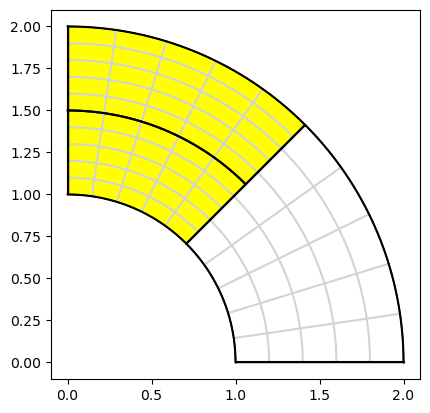

In [55]:
deg = 3
N = 5
#M = checkerboard2(deg,N,1)
M = Tshapes(deg,N,1)
M.set_domain_id({1:{0}})
#M.split_patch(0,axis=1)
#M.split_patch(0,axis=1)
#M.split_patch(2,axis=1)
MP = assemble.Multipatch(M, automatch=True)
dir_data = {0: lambda x,y: 0.}
#MP.set_dirichlet_boundary(dir_data)
f={0:lambda x,y: 1.,1:lambda x,y: 1.}
gamma = 1.
var = 2

#MP.h_refine({0:-1,3:-1})
#MP.h_refine({3:None, 6:None, 8:None, 10:None})
#MP.h_refine({26:None})
MP.set_dirichlet_boundary(dir_data)

a = {0:gamma, 1:1.}
MP.mesh.draw(knots=1, patch_idx=0, color={1:"white", 0:"yellow"})

Kh = sum([MP.assemble_volume(problem='a*inner(grad(u),grad(v))* dx', arity=2, domain_id=d, a=a[d]) for d in MP.mesh.domains])
Fh = sum([MP.assemble_volume(problem='f * v * dx', arity=1, domain_id=d, f=f[d], physical=True) for d in MP.mesh.domains])
dir_bcs = MP.compute_dirichlet_bcs(dir_data)
RL = assemble.RestrictedLinearSystem(Kh,Fh,dir_bcs)
u_exact = RL.complete(scipy.sparse.linalg.spsolve(RL.A,RL.b))

#MP.Constr = parametersort(MP,a)
parametersort(MP,a)
I = IetiDP(MP, dir_data = dir_data, elim=0)
I.assemble(problem='a*inner(grad(u),grad(v))* dx',f=f, a=a)
I.construct_primal_constraints(redundant=False, fat = False)
I.construct_primal_basis()
I.remove_dir_from_system()

F,b = I.compute_F()
F_mat = F@np.eye(F.shape[0])
I.compute_S()

if var==1:
    MsD = MsD_deluxe_whole(I)
elif var==2:
    MsD = MsD_deluxe_whole2(I)
else:
    MsD = I.MsD(method="selection", as_matrix=1)

lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=1, output=1, rtol=1e-6, atol=1e-12)

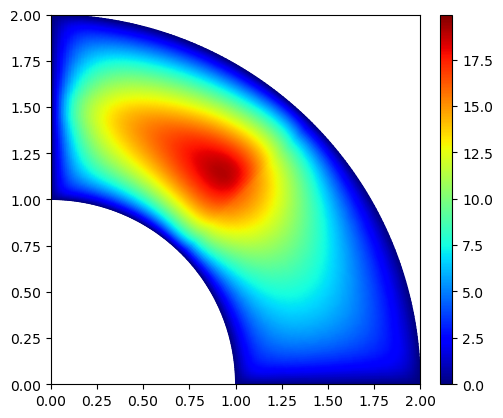

In [56]:
MP.plot(u_exact)

In [57]:
u_IETI = I.construct_solution(lam)

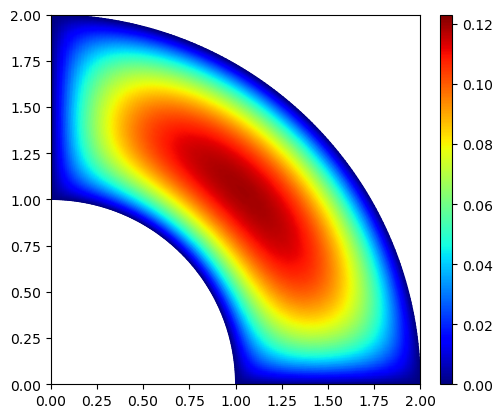

In [58]:
MP.plot(u_IETI)

In [66]:
[MP.assemble_volume(problem='a*inner(grad(u),grad(v))* dx', arity=2, domain_idx=d, a=a[d]) for d in MP.mesh.domains][1].toarray()

array([[ 0.82818, -0.46679, -0.18522, ...,  0.     ,  0.     ,  0.     ],
       [-0.46679,  0.75562,  0.10917, ...,  0.     ,  0.     ,  0.     ],
       [-0.18522,  0.10917,  0.48396, ...,  0.     ,  0.     ,  0.     ],
       ...,
       [ 0.     ,  0.     ,  0.     , ...,  0.64102,  0.08165, -0.37746],
       [ 0.     ,  0.     ,  0.     , ...,  0.08165,  1.28255, -1.00777],
       [ 0.     ,  0.     ,  0.     , ..., -0.37746, -1.00777,  1.50423]])

In [27]:
np.linalg.inv(F_mat)

array([[ 1.50571e+00, -5.05480e-01, -5.10111e-02, -2.18128e-02, -1.11347e-02, -1.44047e-02, -2.39974e-03,  5.90982e-04,  1.80816e-03,  5.00941e-03,  1.02109e-02,  1.05699e-02, -3.86367e-03, -2.42176e-03, -1.50368e-03, -8.68217e-04, -3.91839e-04],
       [-5.05480e-01,  1.51327e+00, -5.62675e-01, -5.75210e-02, -2.66541e-02, -4.52311e-02, -1.02781e-02,  9.63131e-04,  2.78157e-03,  8.02628e-03,  1.95438e-02,  2.36695e-02, -8.35041e-03, -5.10087e-03, -3.11503e-03, -1.78054e-03, -7.99185e-04],
       [-5.10111e-02, -5.62675e-01,  1.56689e+00, -6.04696e-01, -5.71595e-02, -4.24505e-02, -2.69770e-03,  1.09661e-03,  3.01202e-03,  8.07701e-03,  2.71787e-02,  4.50136e-02, -1.51003e-02, -8.82007e-03, -5.23436e-03, -2.93961e-03, -1.30716e-03],
       [-2.18128e-02, -5.75210e-02, -6.04696e-01,  1.62848e+00, -6.43694e-01, -1.05925e-01,  3.18623e-03,  9.40960e-04,  3.07561e-03,  5.29007e-03,  2.71206e-02,  8.59324e-02, -2.72587e-02, -1.49143e-02, -8.48024e-03, -4.63913e-03, -2.03385e-03],
       [-1.1

In [28]:
MsD

<17x17 _CustomLinearOperator with dtype=float64>

In [121]:
eig = np.linalg.eig(MsD@F_mat)

In [122]:
max(abs(eig[0])),min(abs(eig[0]))

(1.849596208383419, 0.4267545242178512)

setting up constraints took 0.01168966293334961 seconds.
Basis setup took 0.0047152042388916016 seconds


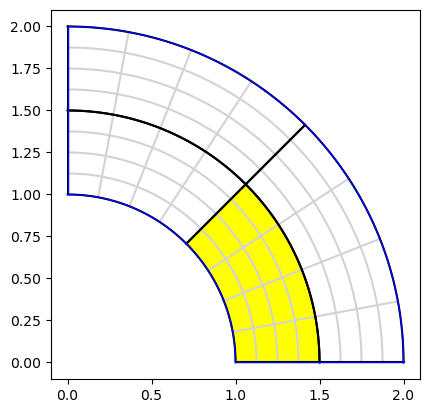

pcg with preconditioned condition number κ ~ 2.7452029063717722 stopped after 7 iterations with relres 2.616776201126164e-07
Residual contributions took 0.03942584991455078 seconds.
Jump contributions took 0.02835679054260254 seconds.
Refinement took 0.010666608810424805 seconds for 4 patches.
setting up constraints took 0.035785675048828125 seconds.
Basis setup took 0.008779048919677734 seconds


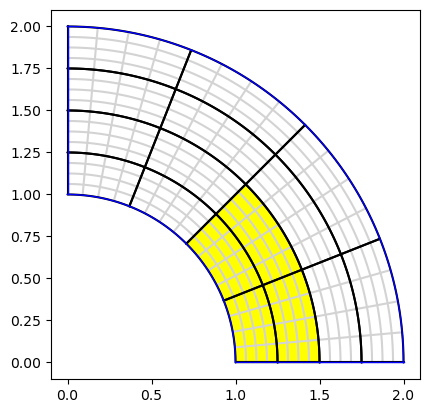

pcg with preconditioned condition number κ ~ 6.72861357885059 stopped after 16 iterations with relres 5.589767243086258e-07
Residual contributions took 0.17499113082885742 seconds.
Jump contributions took 0.1703329086303711 seconds.
Refinement took 0.013641834259033203 seconds for 4 patches.
setting up constraints took 0.07683825492858887 seconds.
Basis setup took 0.014256000518798828 seconds


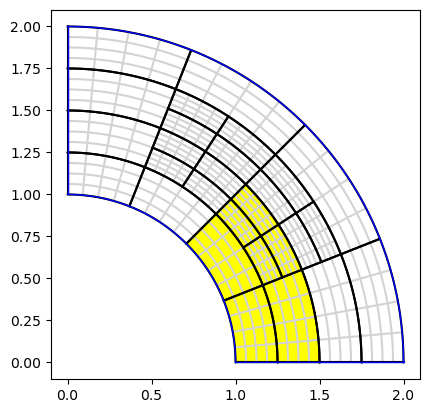

pcg with preconditioned condition number κ ~ 7.315443434473959 stopped after 17 iterations with relres 8.098176930950307e-07
Residual contributions took 0.23935532569885254 seconds.
Jump contributions took 0.38497424125671387 seconds.
Refinement took 0.014939546585083008 seconds for 4 patches.
setting up constraints took 0.1208658218383789 seconds.
Basis setup took 0.014827489852905273 seconds


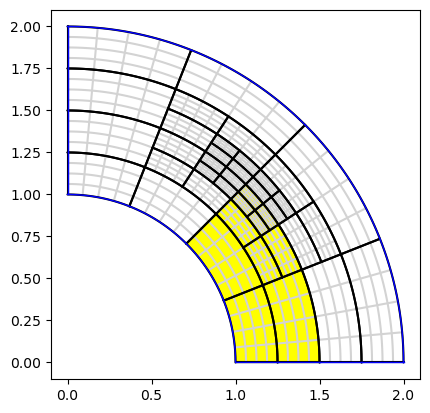

pcg with preconditioned condition number κ ~ 7.458399606084151 stopped after 17 iterations with relres 7.837851323973045e-07
Residual contributions took 0.32190799713134766 seconds.
Jump contributions took 0.5606904029846191 seconds.
Refinement took 0.01720881462097168 seconds for 4 patches.
setting up constraints took 0.16344714164733887 seconds.
Basis setup took 0.021211862564086914 seconds


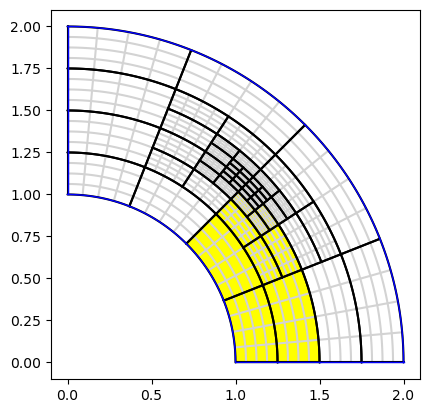

pcg with preconditioned condition number κ ~ 7.3498957823168265 stopped after 18 iterations with relres 5.643755194570303e-07
Residual contributions took 0.4306604862213135 seconds.
Jump contributions took 0.7646200656890869 seconds.
Refinement took 0.024500370025634766 seconds for 5 patches.
setting up constraints took 0.21674108505249023 seconds.
Basis setup took 0.02372002601623535 seconds


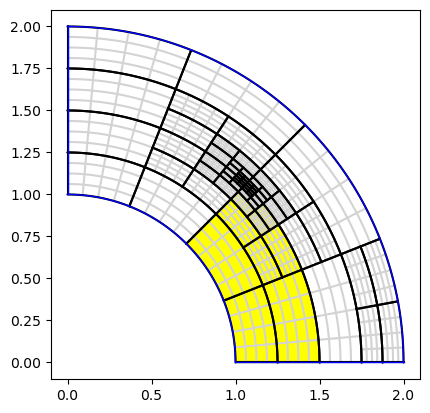

pcg with preconditioned condition number κ ~ 7.245506347402542 stopped after 18 iterations with relres 5.430949537947274e-07
Residual contributions took 0.5657012462615967 seconds.
Jump contributions took 1.002518892288208 seconds.
Refinement took 0.037927865982055664 seconds for 7 patches.
setting up constraints took 0.2815854549407959 seconds.
Basis setup took 0.027727127075195312 seconds


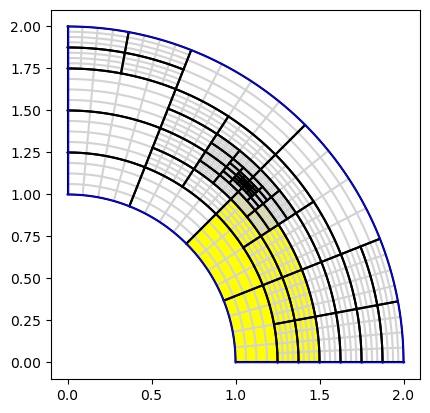

pcg with preconditioned condition number κ ~ 8.374535086504386 stopped after 19 iterations with relres 5.125795779436527e-07
Residual contributions took 0.7502977848052979 seconds.
Jump contributions took 1.3127081394195557 seconds.
Refinement took 0.049541473388671875 seconds for 8 patches.
setting up constraints took 0.3575894832611084 seconds.
Basis setup took 0.033254384994506836 seconds


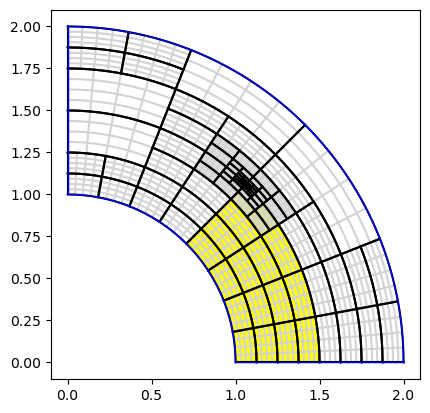

pcg with preconditioned condition number κ ~ 8.416714990316551 stopped after 19 iterations with relres 5.345745864425451e-07
Residual contributions took 0.9529597759246826 seconds.
Jump contributions took 1.6484618186950684 seconds.
Refinement took 0.08716750144958496 seconds for 12 patches.
setting up constraints took 0.4726533889770508 seconds.
Basis setup took 0.04715919494628906 seconds


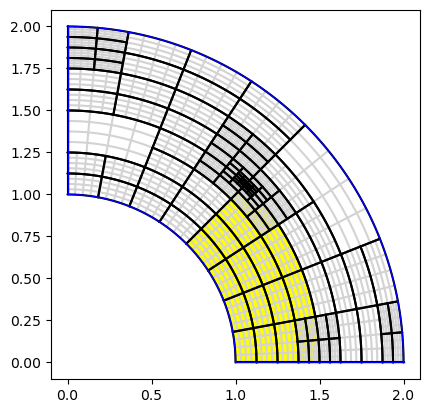

pcg with preconditioned condition number κ ~ 7.647134961604805 stopped after 18 iterations with relres 7.835495834374592e-07
Residual contributions took 1.2643532752990723 seconds.
Jump contributions took 2.171370267868042 seconds.
Refinement took 0.11973309516906738 seconds for 14 patches.
setting up constraints took 0.6067800521850586 seconds.
Basis setup took 0.057746171951293945 seconds


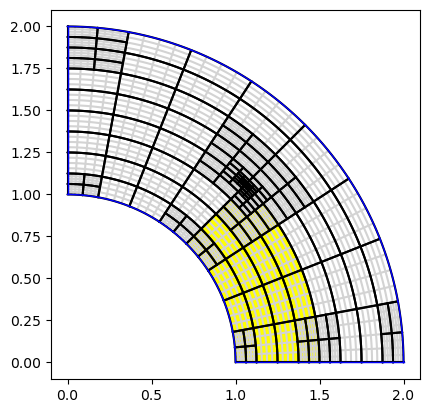

pcg with preconditioned condition number κ ~ 7.928495721587938 stopped after 18 iterations with relres 7.3843630710784e-07
Residual contributions took 1.610138177871704 seconds.
Jump contributions took 2.80285906791687 seconds.
Refinement took 0.17238783836364746 seconds for 17 patches.
setting up constraints took 0.7832551002502441 seconds.
Basis setup took 0.07180547714233398 seconds


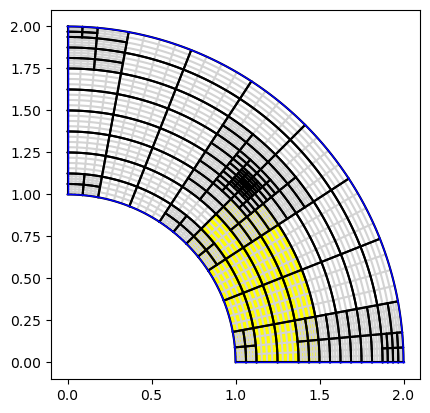

pcg with preconditioned condition number κ ~ 8.31275597889907 stopped after 18 iterations with relres 9.472828132314196e-07
Residual contributions took 2.03961443901062 seconds.
Jump contributions took 3.5777900218963623 seconds.
Refinement took 5.576952695846558 seconds for 241 patches.
setting up constraints took 3.0267231464385986 seconds.
Basis setup took 0.3550267219543457 seconds


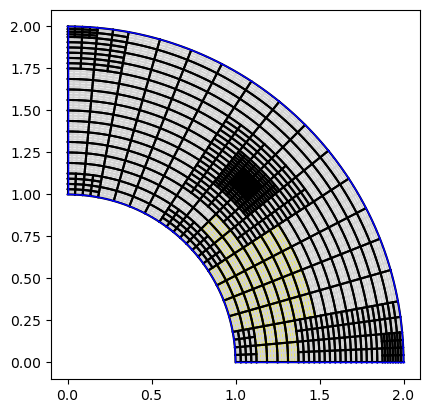

MemoryError: Unable to allocate 449. GiB for an array with shape (964, 7904, 7904) and data type float64

In [31]:
deg = 2
N = 4
M = Heat_annulus(deg,N)
MP = assemble.Multipatch(M, automatch=True)

dir_data = {0: lambda x,y: 0.}
MP.set_dirichlet_boundary(dir_data)
uh=[]
P=[]
err_ind=[]

maxiter=13
numdofs =np.zeros(maxiter)
err_est=np.zeros(maxiter)
a = {0:1., 1:1e4}
f={0:lambda x,y: 1.,1:lambda x,y: 1.}

MP.Constr = parametersort(MP,a)

for k in range(maxiter):
    n_p = MP.numpatches
    MP.mesh.draw(knots=1,patch_idx=0,color={0:'white',1:'yellow'},bcolor={0:'blue'})
    plt.show()

    ###Direct solver
    # bcs = MP.compute_dirichlet_bcs({0:0.})
    # Ah = MP.assemble_volume(vform.stiffness_vf(2,a=a[0]),domain_id=0) + MP.assemble_volume(vform.stiffness_vf(2,a=a[1]),domain_id=1)
    # Kh = MP.assemble_volume(vform.stiffness_vf(2))
    # Mh = MP.assemble_volume(vform.mass_vf(2))
    # F = MP.assemble_volume(vform.L2functional_vf(2, physical=True), f=lambda x,y: 1.)
    # LS = assemble.RestrictedLinearSystem(Ah, F, bcs)
    # uh_k = solvers.make_solver(LS.A)@LS.b
    # uh_k = LS.complete(uh_k)

    ###IETI Solver
    I = IetiDP(MP, dir_data = dir_data, elim=0)
    I.assemble(problem='a*inner(grad(u),grad(v))* dx',f=f, a=a)
    I.construct_primal_constraints(redundant=False, fat = 0)
    I.construct_primal_basis()
    I.remove_dir_from_system()

    F,b = I.compute_F()
    I.compute_S()
    #MsD = I.MsD(method = "selection")
    MsD = MsD_deluxe_whole2(I)

    lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, rtol=1e-6, atol=1e-12)
    uh_k = I.construct_solution(lam)
    
    uh.append(uh_k)
    numdofs[k] = MP.numdofs
    #print(MP_a.numdofs)
    
    if k < maxiter-1 :
        err_ind.append(adap.mp_resPois(MP,uh[k],a=a, f=f))
        err_est[k] = norm(err_ind[-1])
        marked_patches = adap.doerfler_mark(err_ind[-1], 0.9)
        marked_patches = {p:None for p in marked_patches}
        #print(marked_patches)
        MP.h_refine(h_ref=marked_patches,ref="rs")
        MP.set_dirichlet_boundary(dir_data)
        MP.Constr = parametersort(MP,a)
        #P.append(MP.h_refine(h_ref=marked_patches, return_P=True))
        #MP_a.mesh.draw(plt.figure())
    # elif i == maxiter-2:
    #     P.append(MP_a.p_refine(p_inc=1, return_P=True))
    # else:
    #     pass
    
# for k in reversed(range(1,len(P_a))):
#     P_a[k-1]=P_a[k]@P_a[k-1]
    
# L2err_a = np.zeros(maxiter)
# H1err_a = np.zeros(maxiter)
# Aherr_a = np.zeros(maxiter)
# for i in range(len(uh_a)-1):
#     eh = P_a[i]@uh_a[i]-uh_a[-1]
#     L2err_a[i] = eh @ Mh_a @ eh
#     H1err_a[i] = eh @ Kh_a @ eh + L2err_a[-1]
#     Aherr_a[i] = eh @ Ah_a @ eh

# L2err_a = sqrt(L2err_a)
# H1err_a = sqrt(H1err_a)
# Aherr_a = sqrt(Aherr_a)

setting up constraints took 0.007612943649291992 seconds.
Basis setup took 0.0040585994720458984 seconds


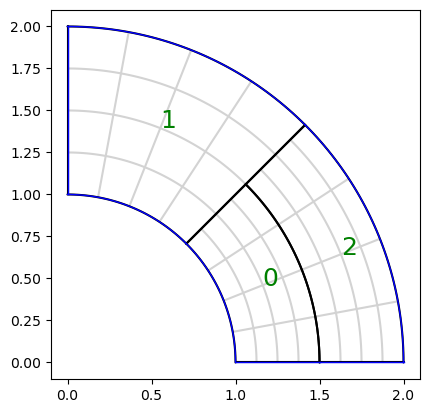

In [27]:
f = lambda x, y: x+y
g = lambda x, y: 0.

params = {'f' : f, 'g' : g}
deg = 1
N = 4
elim=0
fat=0

#M = Heat_annulus(deg,N)
M = topology.PatchMesh(patches=[(2*[bspline.make_knots(deg,0,1,N)],geometry.quarter_annulus())])
M.h_refine({0:0})
M.h_refine({0:1})
# M.h_refine({0:0})
# M.h_refine({1:1})
# M.h_refine({0:1})

#M.h_refine({3:None})
#M.split_patch(0)
#M = Lshape(deg,N,0
#M = topology.PatchMesh(list(zip(5*(2*(bspline.make_knots(deg,0,1,N),),),geometry.mp_disk())))
MP = assemble.Multipatch(M, automatch=True)
dir_data = {0:g}
MP.set_dirichlet_boundary(dir_data)
N = MP.numpatches
MP.mesh.draw(patch_idx=1,nodes=0,knots=1,bcolor={0:'blue'},color={0:'white',1:'yellow'})
I = IetiDP(MP, dir_data = {0:g}, elim=elim)
I.assemble(problem='a*inner(grad(u),grad(v))* dx',f={0:lambda x,y: x+y}, a={0:1.})
I.construct_primal_constraints(redundant=False, fat = fat)
I.construct_primal_basis()
I.remove_dir_from_system()
F,b = I.compute_F()
# F_mat = F@np.eye(*F.shape)
#I.compute_Schur(asmatrix = True)
#print(np.max(I.Psi))
#print(norm(b))
#I.compute_Schur(asmatrix=1)
#MsD = I.MsD(method = "diagonal")
x0 = None
#x0 = np.random.rand(len(b))
#lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=x0, maxiter=200, P=MsD, output=1, rtol=1e-6, atol=1e-12)
#lam, info = scipy.sparse.linalg.cg(F, b, x0=x0, maxiter=2000, M = MsD, rtol=1e-5, atol=1e-12)
#print(info)
#print(min_eig, max_eig)
#u_loc0 = I.construct_solution(lam0)
#u_loc = I.construct_solution(lam)
#MP.plot(np.concatenate(u_loc))

In [35]:
MsD= I.MsD(method = "selection")
S = [s@np.eye(*s.shape) for s in I.S]
M_deluxe = np.zeros(F.shape)
for (p1,p2) in I.intf_dofs:
    print(p1,p2)
    rb1, rb2 = I.Rbb_edges[(p1,p2)]
    rb1I = scipy.sparse.vstack([I.Rii[p1],rb1[rb1.getnnz(1)>0,:]])
    rb2I = scipy.sparse.vstack([I.Rii[p2],rb2[rb2.getnnz(1)>0,:]])
    A1 = rb1I@I.Ak[p1]@rb1I.T
    A2 = rb2I@I.Ak[p2]@rb2I.T
    B1 = I.Bk[p1]@rb1I.T
    B2 = I.Bk[p2]@rb2I.T

    idx = I.intf_dofs[(p1,p2)][1]
    c_idx = I.B[:,idx].tocsc().indices
    rb1, rb2 = I.Rbb_edges[(p1,p2)]
    rb1 = rb1[:,rb1.getnnz(0)>0]
    rb2 = rb2[:,rb2.getnnz(0)>0]

    s1 = rb1.T@S[p1]@rb1
    s2 = rb2.T@S[p2]@rb2
    P = I.B_gamma[:,I.S_ofs[p1]:I.S_ofs[p1+1]]@rb1
    P = P[c_idx,:]

    P2 = I.B_gamma[:,I.S_ofs[p2]:I.S_ofs[p2+1]]@rb2[:,rb2.getnnz(0)>0]
                
    #Z = scipy.sparse.hstack([B1,B2])
    r_idx = B2.getnnz(1)>0
    B1=B1[r_idx ,:]
    B2=B2[r_idx ,:]
    #print(B1.toarray(),B2.toarray())
    n_c = sum(r_idx)

    Mat = -scipy.sparse.block_array([[A1,None,B1.T],[None,A2,B2.T],[B1,B2,None]])
    #print(Mat.toarray())
    # spy(Mat,markersize=1)
    # plt.show()
    n = Mat.shape[0]
    X = aslinearoperator(P2@scipy.sparse.hstack([scipy.sparse.csc_matrix((n_c,n-n_c)),scipy.sparse.identity(n_c, format='csc')]))
    #print(n_c,X@np.eye(X.shape[1]))
    Mat_inv = solvers.make_solver(Mat, spd=False, symmetric=True)
    #print(Mat_inv.toarray())
    print((X@Mat_inv@X.T)@np.eye(X.shape[0]))
    print(P2@np.linalg.inv(np.linalg.inv(s2) + P@np.linalg.inv(s1)@P.T)@P2.T)
    print("===========================================================================================================================================================")

Convergence condition: 0.0
1 0
[[ 1.51761 -0.61938 -0.0595   0.       0.       0.       0.       0.       0.     ]
 [-0.61938  1.16221 -0.68892  0.       0.       0.       0.       0.       0.     ]
 [-0.0595  -0.68892  1.69235  0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.       0.     ]]
[[ 1.51761 -0.61938 -0.0595   0.       0.       0.       0.       0.       0.     ]
 [-0.61938  1.16221 -0.68892  0.       0.       0.       0.       0.       0.     ]
 [-0.0595  -0.68892  1.69235  0.       0.   

In [ ]:
np.hstack([np.zeros(shape=(len(c_idx),rb1.shape[0]+rb2.shape[0])),np.eye(len(c_idx))])

In [ ]:
rb2

In [44]:
rb2_tilde.toarray()

array([[0., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [ ]:
MsD= I.MsD(method = "deluxe")

In [38]:
algebra.condest(F_mat)

145.87277360530817

In [39]:
MsD = MsD@np.eye(*F.shape)

In [40]:
algebra.condest(MsD@F_mat)

20.168438075051302

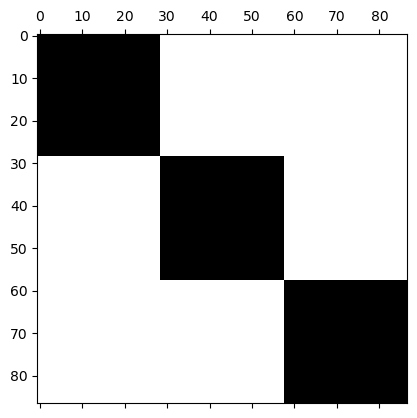

In [156]:
spy(MsD)

deg = 2
setting up constraints took 0.020328521728515625 seconds.
Basis setup took 0.008057832717895508 seconds
pcg with preconditioned condition number κ ~ 4.866912722164114 stopped after 12 iterations with relres 4.0196249089061476e-07
#####################################################
setting up constraints took 0.021007776260375977 seconds.
Basis setup took 0.008074045181274414 seconds
pcg with preconditioned condition number κ ~ 6.844477130703723 stopped after 15 iterations with relres 1.2527597848017955e-07
#####################################################
setting up constraints took 0.02991962432861328 seconds.
Basis setup took 0.016133785247802734 seconds
pcg with preconditioned condition number κ ~ 9.146446269810777 stopped after 16 iterations with relres 8.252901247665778e-07
#####################################################
deg = 3
setting up constraints took 0.021846532821655273 seconds.
Basis setup took 0.007699489593505859 seconds
pcg with preconditioned condit

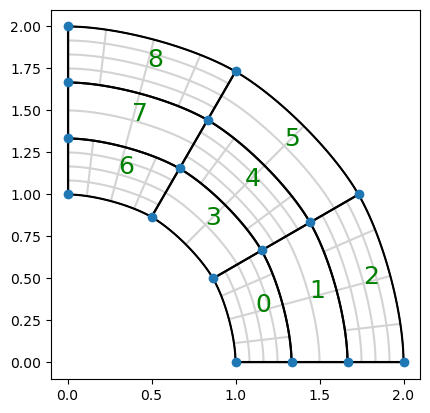

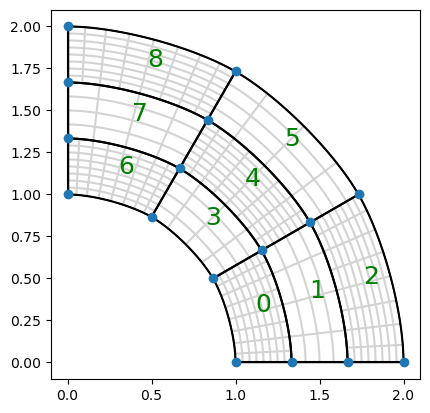

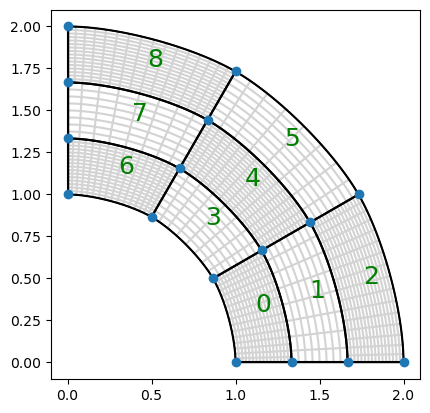

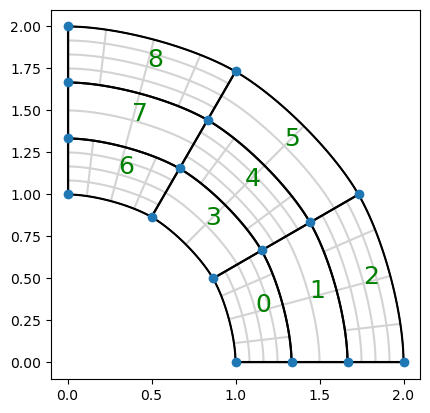

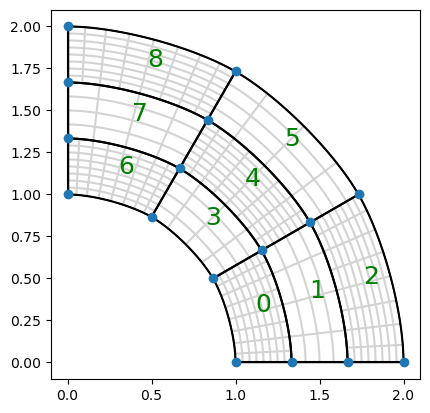

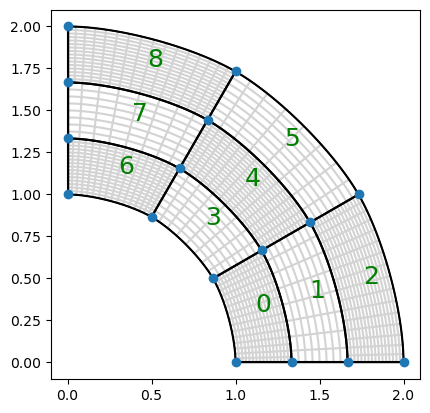

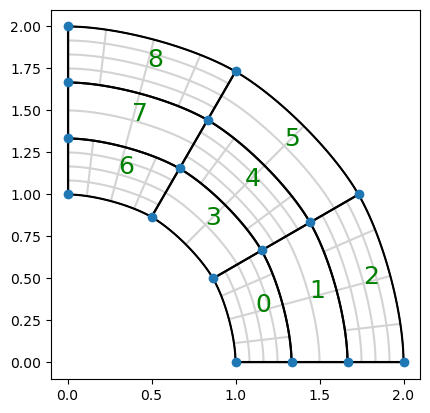

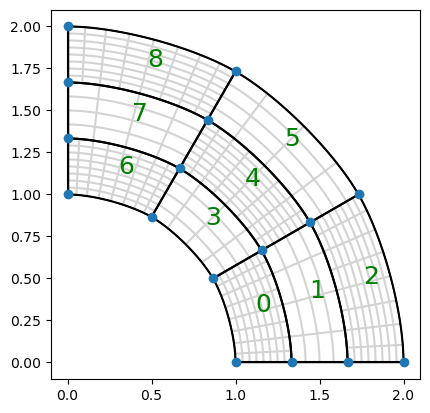

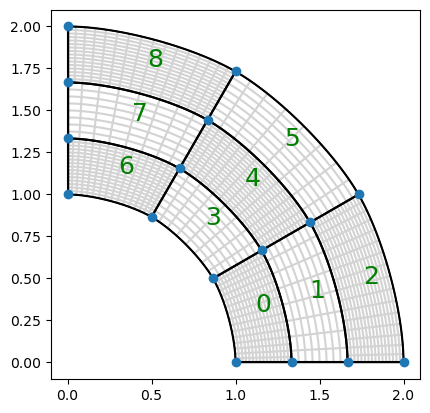

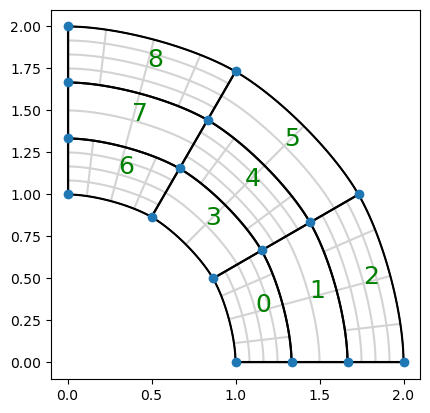

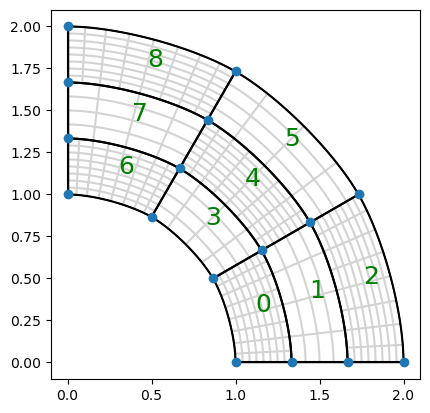

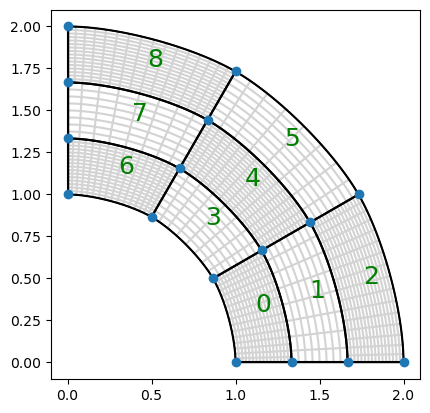

In [119]:
# f = lambda x, y: 1.
g = lambda x, y: 0. 

#params = {'f' : f, 'g' : g}
degs=(2,3,5,8)
maxiter=len(degs)*(3,)
elim=0
fat=0
export=1
a={0:1e6,1:1.}

# num_dofs = np.empty((len(maxiter),len(deg)),dtype=int)
# num_primal = np.empty((len(maxiter),len(deg)),dtype=int)
# min_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# max_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# it = np.empty((len(maxiter),len(deg)),dtype=int)

k=2
res = np.zeros((max(maxiter),len(degs)*k), dtype=float)

for j, deg in enumerate(degs):
    print("======================================================")
    print("deg = "+str(deg))
    for i in range(maxiter[j]):
        M = checkerboard2(deg,2**(i+1),1)
        M.set_domain_id({1:{1,3,5,7}})
        MP = assemble.Multipatch(M, automatch=True)
        N = MP.numpatches
        MP.set_dirichlet_boundary({0:g})
        MP.mesh.draw(patch_idx=1,nodes=1,knots=1)
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(problem='a * inner( grad(u) , grad(v) )* dx', f={0:lambda x,y: 1.,1:lambda x,y: 1.}, a=a)
        I.construct_primal_constraints(redundant=False, fat=fat)
        I.construct_primal_basis()
        #res[i,k*j] = I.Psi.shape[1]
        I.remove_dir_from_system()
        F,b= I.compute_F()
        #F_mat = F@np.eye(len(b))
        #I.compute_Schur()
        MsD = I.MsD(method="deluxe")
        #MsD_mat = MsD@np.eye(len(b))
        ### Solve the system with PCG
        lam, res[i,k*j], min_eig, max_eig, r = solvers.pcg(F, b, x0=np.random.rand(len(b)), maxiter=2000, P=MsD, output=1, rtol=1e-6, atol=1e-12)
        res[i, k*j+1] = abs(max_eig/min_eig)
        #print(min_eig, max_eig)
        #w = I.construct_solution(lam)
        print("#####################################################")
if export:
    if elim:
        np.savetxt('/home/wolfman/Documents/IETI/checkerboard_elim.txt', res, fmt=len(degs)*('%d','%1.2f'), delimiter = " & ")   
    else:
        np.savetxt('/home/wolfman/Documents/IETI/checkerboard.txt', res, fmt=len(degs)*('%d','%1.2f'), delimiter = " & ")   

In [ ]:
f = lambda x, y: 1.
g = lambda x, y: 0. 

params = {'f' : f, 'g' : g}
degs=(2,3,4,5,6,7,8)
maxiter=len(degs)*(6,)
elim=0
fat=0
export=1

# num_dofs = np.empty((len(maxiter),len(deg)),dtype=int)
# num_primal = np.empty((len(maxiter),len(deg)),dtype=int)
# min_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# max_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# it = np.empty((len(maxiter),len(deg)),dtype=int)

k=2
res = np.zeros((max(maxiter),len(degs)*k), dtype=float)

for j, deg in enumerate(degs):
    print("======================================================")
    print("deg = "+str(deg))
    for d in range(maxiter[j]):
        M = checkerboard1(deg,2,d+1)
        MP = assemble.Multipatch(M, automatch=True)
        MP.set_dirichlet_boundary({0:g})
        #MP.mesh.draw(patch_idx=1,nodes=1,knots=1)
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(problem='(inner(grad(u),grad(v)))* dx',f={ k:lambda x,y: 1. for k in range(N)}, a={ k:lambda x,y: 1. for k in range(N)})
        I.construct_primal_constraints(redundant=False, fat=fat)
        I.construct_primal_basis()
        #res[i,k*j] = I.Psi.shape[1]
        I.remove_dir_from_jumps()
        F,b= I.compute_F()
        #F_mat = F@np.eye(len(b))
        MsD = I.MsD(method="choice")
        #MsD_mat = MsD@np.eye(len(b))
        ### Solve the system with PCG
        lam, res[d,k*j], min_eig, max_eig, r = solvers.pcg(F, b, x0=np.random.rand(len(b)), maxiter=100, P=MsD, output=1, rtol=1e-6, atol=1e-12)
        res[d, k*j+1] = abs(max_eig/min_eig)
        #print(min_eig, max_eig)
        #w = I.construct_solution(lam)
        print("#####################################################")
if export:
    if elim:
        np.savetxt('/home/wolfman/Documents/IETI/checkerboard_elim_dis.txt', res, fmt=len(degs)*('%d','%1.2f'), delimiter = " & ")   
    else:
        np.savetxt('/home/wolfman/Documents/IETI/checkerboard_dis.txt', res, fmt=len(degs)*('%d','%1.2f'), delimiter = " & ")   

In [165]:
f = lambda x, y: 1.
g = lambda x, y: 0. 

params = {'f' : f, 'g' : g}
degs=(2,3,5,8)
maxiter=len(degs)*(4,)
elim=0
fat=0
export=1

# num_dofs = np.empty((len(maxiter),len(deg)),dtype=int)
# num_primal = np.empty((len(maxiter),len(deg)),dtype=int)
# min_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# max_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# it = np.empty((len(maxiter),len(deg)),dtype=int)

k=2
res = np.zeros((max(maxiter),len(degs)*k), dtype=float)

for j, deg in enumerate(degs):
    print("======================================================")
    print("deg = "+str(deg))
    for i in range(maxiter[j]):
        M = Lshape(deg,2**(i+1),5)
        MP = assemble.Multipatch(M, automatch=True)
        N = MP.numpatches
        #res[i,k*j] = MP.N_ofs[-1]
        MP.set_dirichlet_boundary({0:g})
        #MP.mesh.draw(patch_idx=1,nodes=1,knots=1)
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(problem='(inner(grad(u),grad(v)))* dx',f={ k:lambda x,y: 1. for k in range(N)}, a={ k:lambda x,y: 1. for k in range(N)})
        I.construct_primal_constraints(redundant=False, fat=fat)
        I.construct_primal_basis()
        print(I.Psi.shape[1])
        I.remove_dir_from_system()
        F,b= I.compute_F()
        #F_mat = F@np.eye(len(b))
        MsD = I.MsD(method="deluxe")
        #MsD_mat = MsD@np.eye(len(b))
        ### Solve the system with PCG
        #x0=np.random.rand(len(b))
        x0=None
        lam, res[i,k*j], min_eig, max_eig, r = solvers.pcg(F, b, x0=x0, maxiter=200, P=MsD, output=1, rtol=1e-6, atol=1e-12)
        #print(min_eig, max_eig)
        res[i,k*j+1]=abs(max_eig/min_eig)
        #print(min_eig, max_eig)
        #w = I.construct_solution(lam)
        print("#####################################################")
if export:
    if elim:
        if fat:
            np.savetxt('/home/wolfman/Documents/IETI/Lshape_elim_fat.txt', res, fmt=len(degs)*('%d', '%1.2f'), delimiter = " & ")   
        else:
            np.savetxt('/home/wolfman/Documents/IETI/Lshape_elim.txt', res, fmt=len(degs)*('%d', '%1.2f'), delimiter = " & ") 
    else:
        np.savetxt('/home/wolfman/Documents/IETI/Lshape.txt', res, fmt=len(degs)*('%d', '%1.2f'), delimiter = " & ")   

deg = 2
setting up constraints took 0.13743233680725098 seconds.
Basis setup took 0.0164334774017334 seconds
49
pcg with preconditioned condition number κ ~ 5.672835943596938 stopped after 16 iterations with relres 4.6732528639194114e-07
#####################################################
setting up constraints took 0.142197847366333 seconds.
Basis setup took 0.016907453536987305 seconds
49
pcg with preconditioned condition number κ ~ 8.81675154323183 stopped after 18 iterations with relres 5.947188239080794e-07
#####################################################
setting up constraints took 0.15126681327819824 seconds.
Basis setup took 0.019551753997802734 seconds
49
pcg with preconditioned condition number κ ~ 13.437801942087457 stopped after 21 iterations with relres 5.856498528403269e-07
#####################################################
setting up constraints took 0.1742088794708252 seconds.
Basis setup took 0.02640557289123535 seconds
49
pcg with preconditioned condition nu

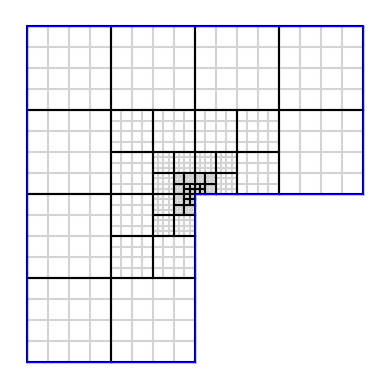

In [27]:
M = Lshape(1,4,5)
M.draw(bcolor={0:'blue'}, nodes=0, knots=1)
axis('off');

In [8]:
I.Ck

[<1x36 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Row format>,
 <2x42 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Row format>,
 <2x42 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Row format>,
 <1x36 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Row format>,
 <2x42 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Row format>,
 <2x42 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Row format>,
 <3x49 sparse matrix of type '<class 'numpy.float64'>'
 	with 3 stored elements in Compressed Sparse Row format>,
 <1x36 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Row format>,
 <2x42 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compr

In [9]:
I.Prim

{0: (array([ 48, 189, 202, 245], dtype=int32), array([1., 1., 1., 1.])),
 1: (array([ 97, 336, 349, 392], dtype=int32), array([1., 1., 1., 1.])),
 2: (array([140, 342, 398, 490], dtype=int32), array([1., 1., 1., 1.])),
 3: (array([146, 483, 496, 539], dtype=int32), array([1., 1., 1., 1.])),
 4: (array([ 55, 244, 287, 294], dtype=int32), array([1., 1., 1., 1.]))}

In [10]:
MP.get_nodes()

{48: [array([ 48, 189, 202, 245], dtype=int32)],
 96: [array([ 97, 336, 349, 392], dtype=int32)],
 138: [array([140, 342, 398, 490], dtype=int32)],
 144: [array([146, 483, 496, 539], dtype=int32)],
 252: [array([ 55, 244, 287, 294], dtype=int32)]}

#####################################
setting up constraints took 0.018363237380981445 seconds.
Basis setup took 0.009409666061401367 seconds
4
10
pcg with preconditioned condition number 1.1104232399228329 stopped after 2 iterations with relres 5.4951067048262263e-17
Refinement took 0.00043201446533203125 seconds for 9 patches.
setting up constraints took 0.020048141479492188 seconds.
Basis setup took 0.009725570678710938 seconds
7
26
pcg with preconditioned condition number 1.242827242377967 stopped after 6 iterations with relres 9.877262513024327e-15
Refinement took 0.000331878662109375 seconds for 9 patches.
setting up constraints took 0.023079395294189453 seconds.
Basis setup took 0.01008152961730957 seconds
8
23
pcg with preconditioned condition number 1.3131180431114824 stopped after 6 iterations with relres 7.19027091678448e-11
Refinement took 0.0003571510314941406 seconds for 9 patches.
setting up constraints took 0.029850244522094727 seconds.
Basis setup took 0.01311326026916

/home/wolfman/anaconda3/lib/python3.9/site-packages/pyiga-0.1.0-py3.9-linux-x86_64.egg/pyiga/topology.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=kwargs.get('figsize'))


21
25
pcg with preconditioned condition number 1.769266987585349 stopped after 11 iterations with relres 2.2424118613517237e-11
Refinement took 0.0003402233123779297 seconds for 9 patches.
setting up constraints took 0.03714632987976074 seconds.
Basis setup took 0.018062114715576172 seconds
24
24
pcg with preconditioned condition number 1.7675684065257513 stopped after 11 iterations with relres 8.781202012645705e-11
Refinement took 0.00039577484130859375 seconds for 9 patches.
setting up constraints took 0.06232929229736328 seconds.
Basis setup took 0.034009695053100586 seconds
25
24
pcg with preconditioned condition number 1.7590407403296329 stopped after 12 iterations with relres 2.639155553047284e-11
Refinement took 0.00043511390686035156 seconds for 9 patches.
setting up constraints took 0.11404061317443848 seconds.
Basis setup took 0.09270548820495605 seconds


KeyboardInterrupt: 

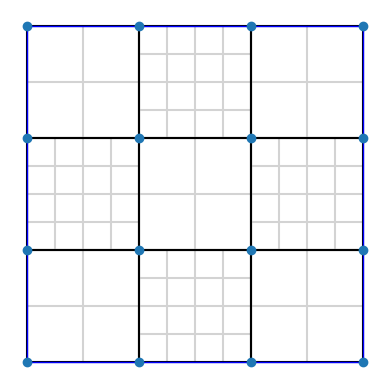

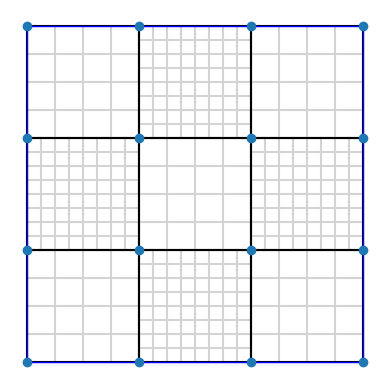

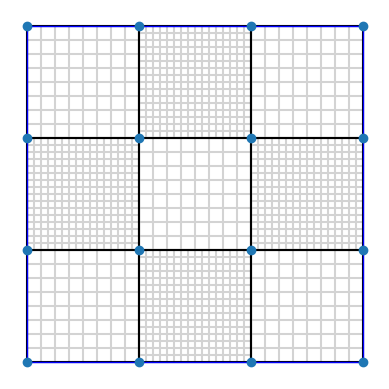

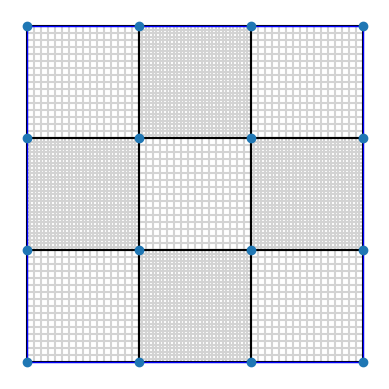

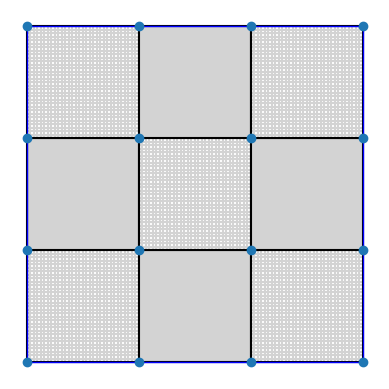

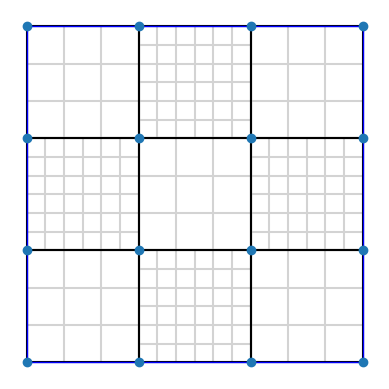

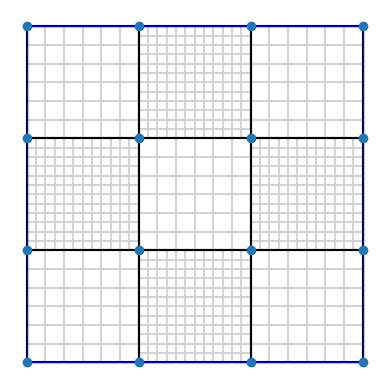

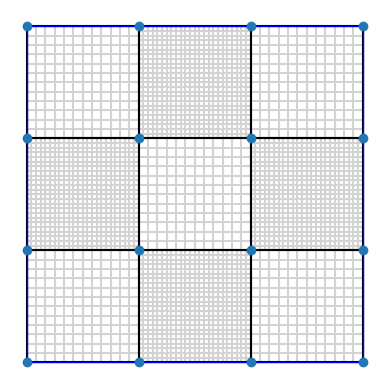

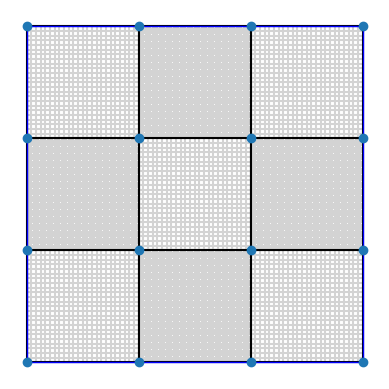

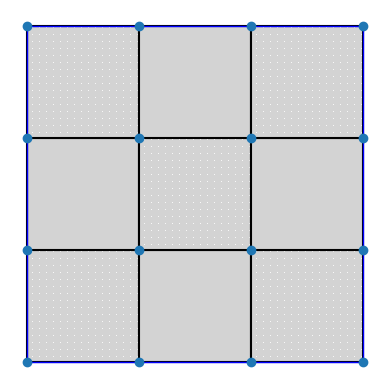

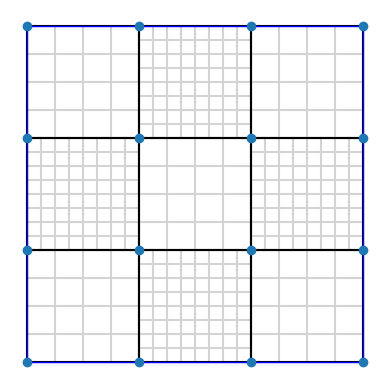

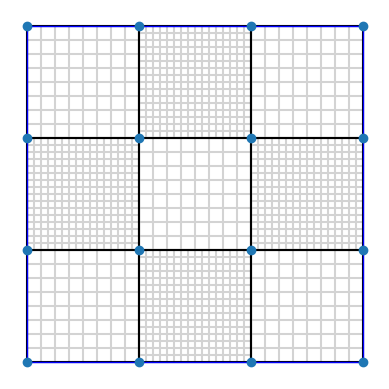

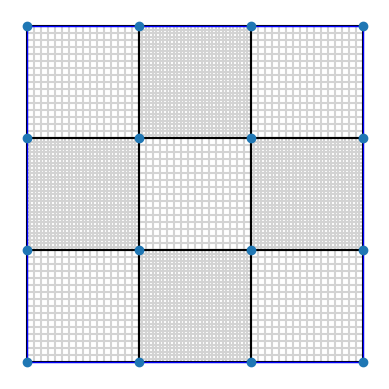

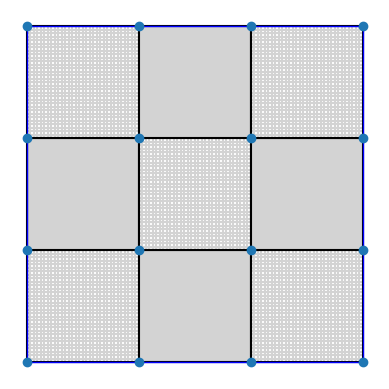

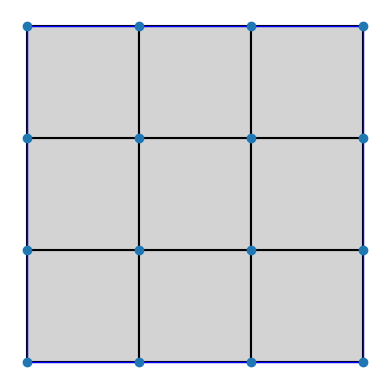

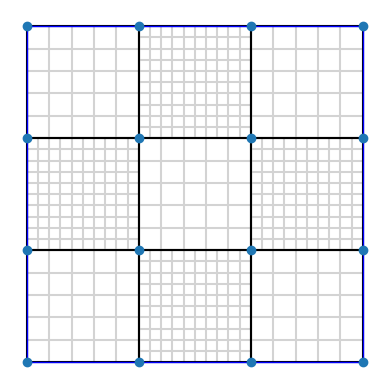

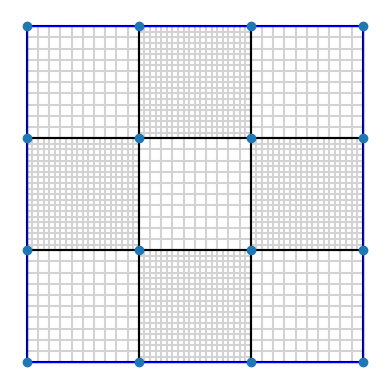

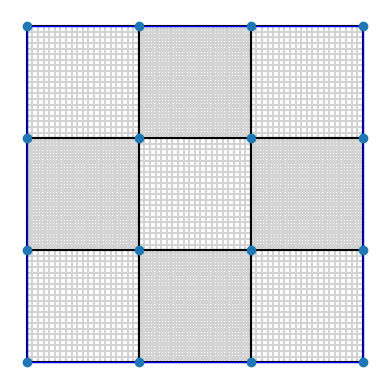

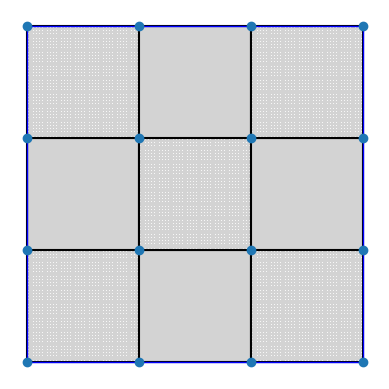

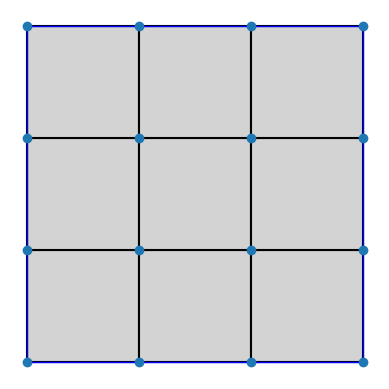

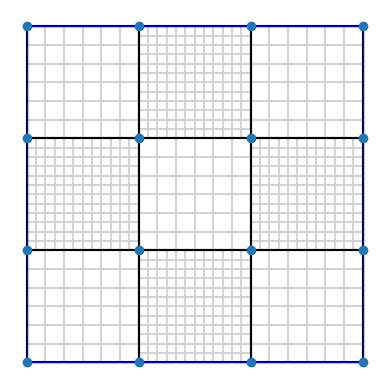

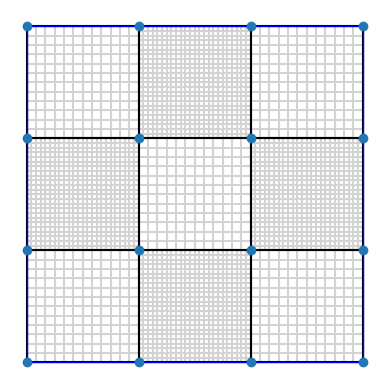

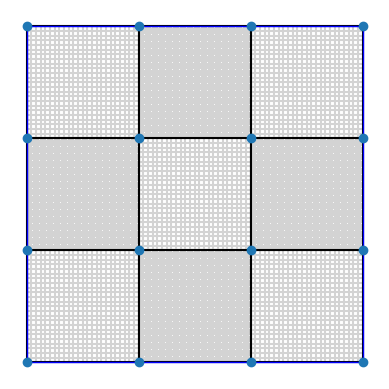

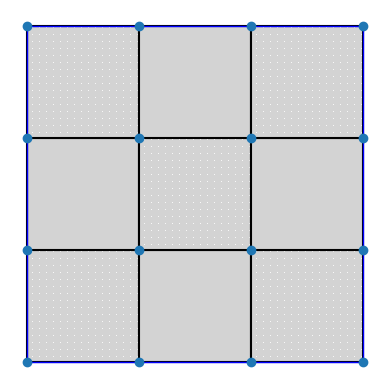

In [16]:
# source term f and Dirichlet boundary function g
f = lambda x, y: 1.
g = lambda x, y: 0. 

kappa = np.zeros((5,5))
it = np.zeros((5,5))
elim=False

for p, (deg, maxiter) in enumerate(zip((1,2,3,4,5),5*(5,))):
    print('#####################################')
    M = checkerboard(deg,deg+1,1)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    for i in range(maxiter):
        print('=====================================')
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(f=lambda x,y: 1.)
        I.construct_primal_constraints()
        I.construct_primal_basis()
        F,b= I.compute_F()
        MsD = I.MsD(pseudo=True)
        Fmat  = F.dot(np.eye(F.shape[0]))
        kappa[i,p]=algebra.condest(MsD@Fmat)
        lam, it[i,p], kappa[i,p], r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-10)
        #MP.mesh.draw(patch_idx = 0, knots=1, bcolor={0:'blue'}, nodes=1, axis='off')
        axis('scaled');
        MP.h_refine(-1)
        ###MP.h_refine({i : -1 for i in range(9) if i%2==1})
        MP.set_dirichlet_boundary({0:g})
        
result = np.zeros((5,10))
result[:,np.array([0,2,4,6,8])]=kappa
result[:,np.array([1,3,5,7,9])]=it

if elim:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard_elim.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")
else:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")              

#####################################
setting up constraints took 0.017437458038330078 seconds.
Basis setup took 0.009253501892089844 seconds
pcg stopped after 2 iterations with relres 5.4951067048262263e-17
Refinement took 0.00016951560974121094 seconds for 4 patches.
setting up constraints took 0.01792740821838379 seconds.
Basis setup took 0.00933218002319336 seconds
pcg stopped after 4 iterations with relres 4.273988115438311e-17
Refinement took 0.0001652240753173828 seconds for 4 patches.
setting up constraints took 0.019681930541992188 seconds.
Basis setup took 0.009746074676513672 seconds
pcg stopped after 4 iterations with relres 9.358588499822341e-15
Refinement took 0.00015854835510253906 seconds for 4 patches.
setting up constraints took 0.021558284759521484 seconds.
Basis setup took 0.011844396591186523 seconds
pcg stopped after 4 iterations with relres 4.58228236822898e-13
Refinement took 0.00017547607421875 seconds for 4 patches.
setting up constraints took 0.02753949165344

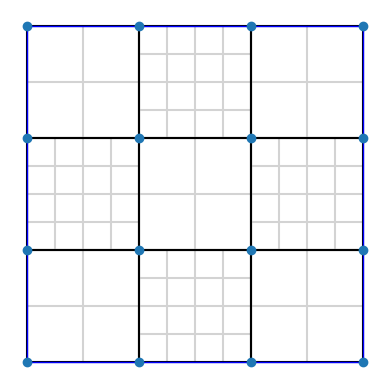

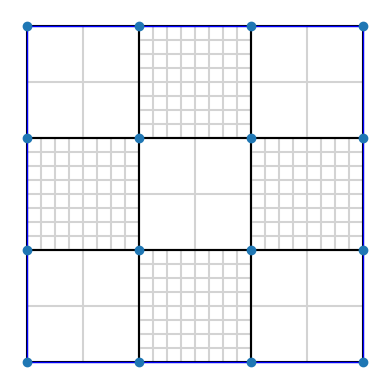

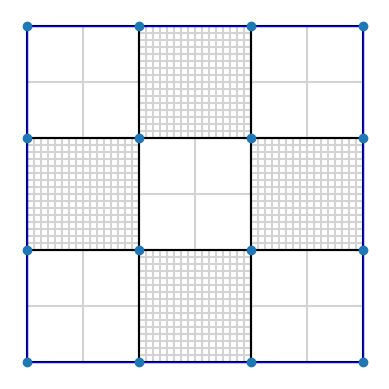

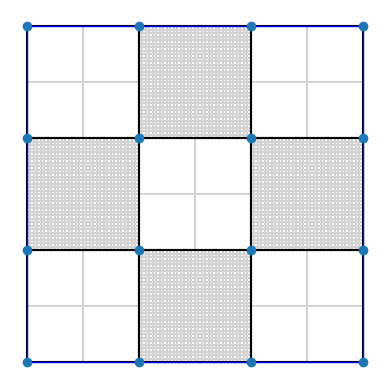

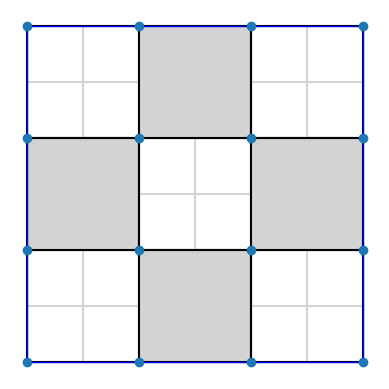

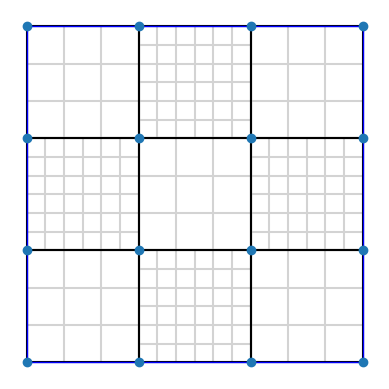

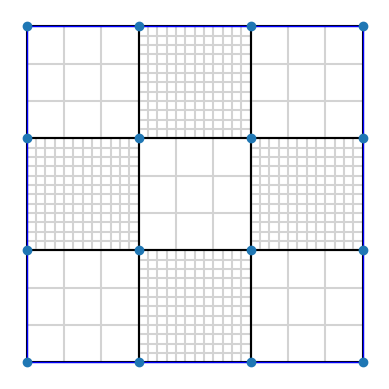

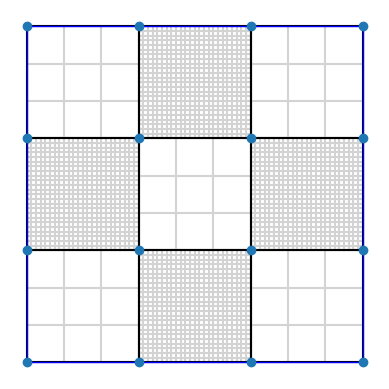

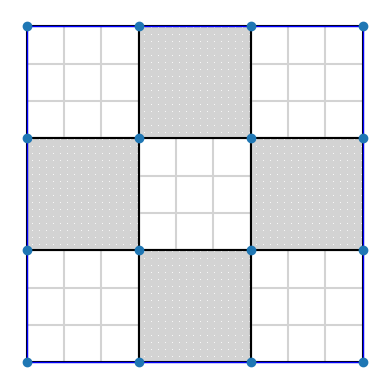

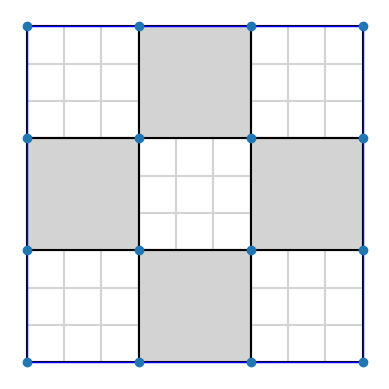

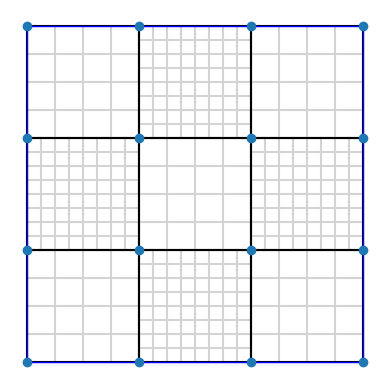

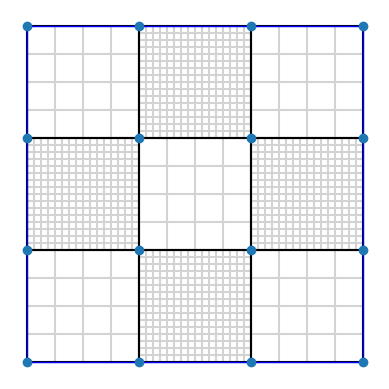

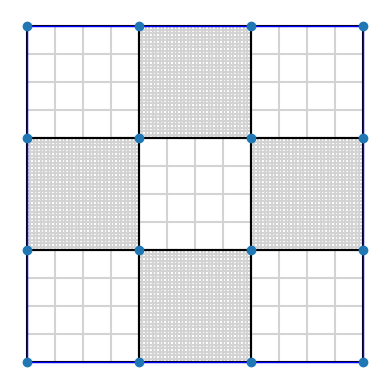

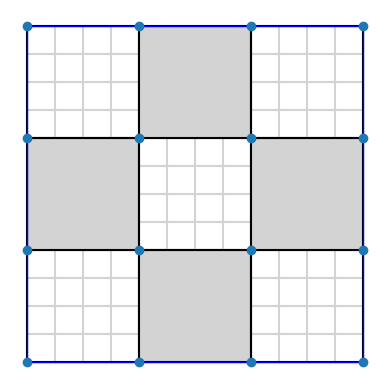

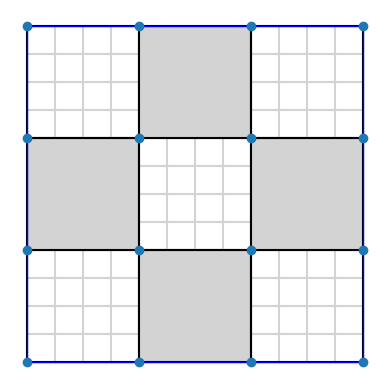

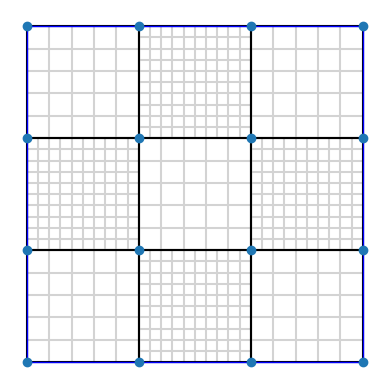

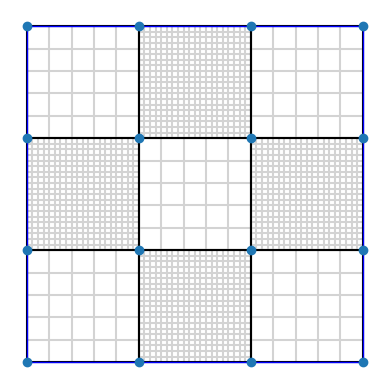

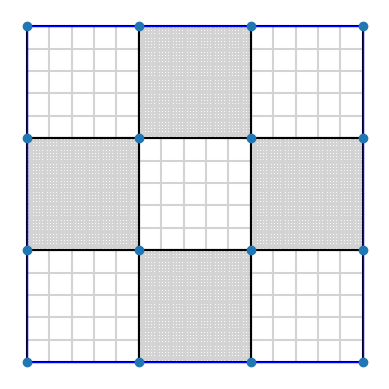

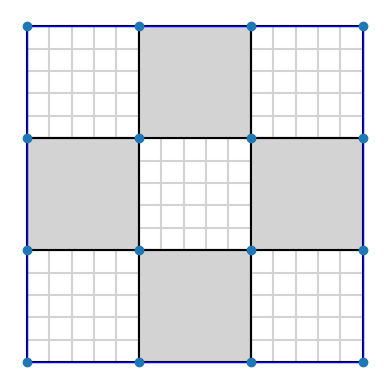

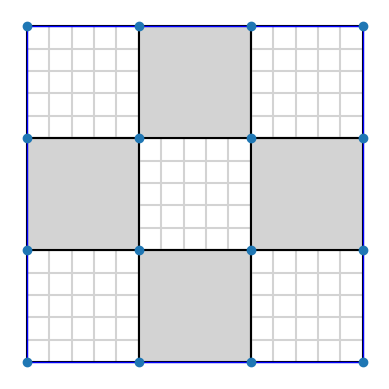

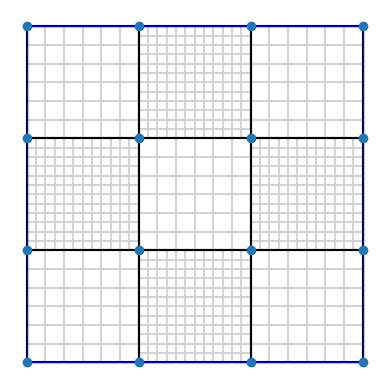

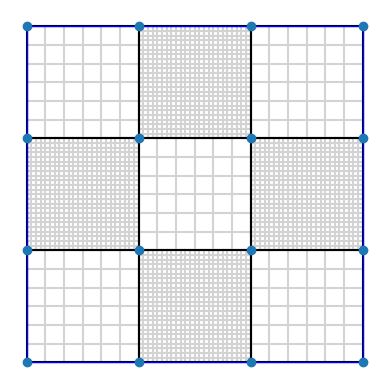

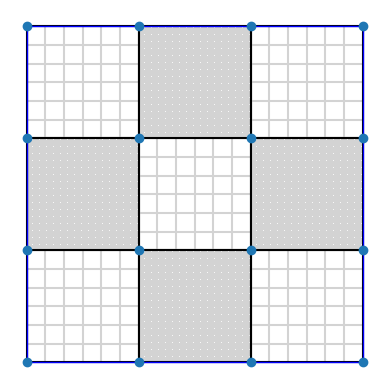

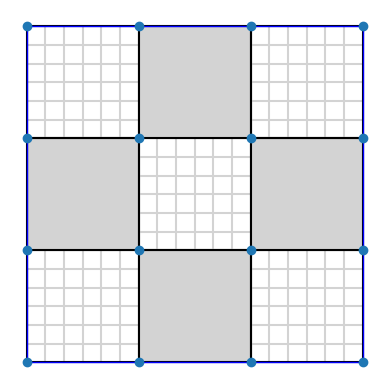

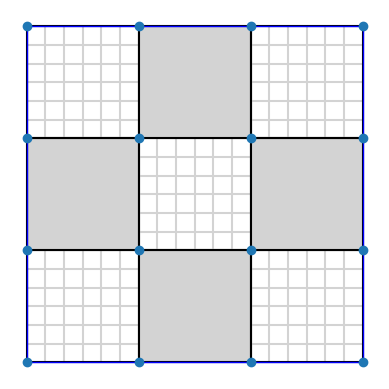

In [49]:
# source term f and Dirichlet boundary function g
f = lambda x, y: 1.
g = lambda x, y: 0. 

kappa = np.zeros((5,5))
it = np.zeros((5,5))
elim=False

for p, (deg, maxiter) in enumerate(zip((1,2,3,4,5),5*(5,))):
    print('#####################################')
    M = checkerboard(deg,deg+1,1)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    for i in range(maxiter):
        print('=====================================')
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(f=lambda x,y: 1.)
        I.construct_primal_constraints()
        I.construct_primal_basis()
        F,b= I.compute_F()
        MsD = I.MsD()
        Fmat  = F.dot(np.eye(F.shape[0]))
        kappa[i,p]=algebra.condest(MsD@Fmat)
        lam, it[i,p], r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-10)
        #MP.mesh.draw(patch_idx = 0, knots=1, bcolor={0:'blue'}, nodes=1, axis='off')
        axis('scaled');
        ###MP.h_refine(-1)
        MP.h_refine({i : -1 for i in range(9) if i%2==1})
        MP.set_dirichlet_boundary({0:g})
        
result = np.zeros((5,10))
result[:,np.array([0,2,4,6,8])]=kappa
result[:,np.array([1,3,5,7,9])]=it

if elim:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard_elim_dis.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")
else:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard_dis.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")              

In [ ]:
# source term f and Dirichlet boundary function g
f = lambda x, y: 1.
g = lambda x, y: 0. 

kappa = np.zeros((6,5))
it = np.zeros((6,5))
elim=True

for p, (deg, maxiter) in enumerate(zip((1,2,3,4,5),5*(6,))):
    print('#####################################')
    M = Lshape(deg,deg+1)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    for i in range(maxiter):
        print('=====================================')
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(f=lambda x,y: 1.)
        I.construct_primal_constraints()
        I.construct_primal_basis()
        F,b= I.compute_F()
        MsD = I.MsD(pseudo=False)
        lam, it[i,p], kappa[i,p], r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-10)
        axis('scaled');
        MP.h_refine(-1)
        ###MP.h_refine({i : -1 for i in range(9) if i%2==1})
        MP.set_dirichlet_boundary({0:g})
        
result = np.zeros((5,10))
result[:,np.array([0,2,4,6,8])]=kappa
result[:,np.array([1,3,5,7,9])]=it

if elim:
    np.savetxt('/home/wolfman/Documents/IETI/Lshape_elim.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")
else:
    np.savetxt('/home/wolfman/Documents/IETI/Lshape.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")              

#####################################
setting up constraints took 0.08600449562072754 seconds.
Basis setup took 0.014266014099121094 seconds
pcg with preconditioned condition number 1.0972303562262358 stopped after 5 iterations with relres 2.1033830757006824e-11
Refinement took 0.0010564327239990234 seconds for 31 patches.
setting up constraints took 0.07834243774414062 seconds.
Basis setup took 0.013842582702636719 seconds
pcg with preconditioned condition number 1.671463683434546 stopped after 10 iterations with relres 4.9938397508517634e-11
Refinement took 0.0012252330780029297 seconds for 31 patches.
setting up constraints took 0.08354926109313965 seconds.
Basis setup took 0.015346527099609375 seconds
pcg with preconditioned condition number 1.2749844484684212 stopped after 13 iterations with relres 3.0492980297062935e-11
Refinement took 0.00106048583984375 seconds for 31 patches.
setting up constraints took 0.1029202938079834 seconds.
Basis setup took 0.020825624465942383 seconds
